**NLP**

*CC6205-1 - Otoño 2022*

Autor: Felipe Urrutia Vargas

In [1]:
# !pip install --upgrade pandas

import pandas as pd
import numpy as np
# pd.set_option("max_rows", None)
import pickle
from string import punctuation
import re

from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
# from astropy.visualization import hist
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})
import random

import plotly.express as px

In [2]:
sentiments = "anger fear joy sadness".split()
intensities = "low medium high".split()

In [6]:
df_train = pickle.load(open("df_train.pickle", "rb"))

In [4]:
#import spacy library
import spacy

!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
vocab_joy = {i: [] for i in intensities}
for i in intensities:
    _sub = df_train[(df_train["sen"] == "joy") & (df_train["int"] == i)]
    for text in _sub["text"]:
        doc = nlp(text)
        for t in doc:
            vocab_joy[i].append(t.text.lower())

In [7]:
import collections

In [9]:
!pip install unidecode
from unidecode import unidecode

!pip install Levenshtein
import Levenshtein as lev

In [10]:
import emojilib

In [11]:
vowel = "aeiou"
digit = "0123456789"

def replace_multiple(string, list_replace, replace_ch):
    for ch in list_replace:
        if ch in string:
            string = string.replace(ch, replace_ch)
    return string

def sim_lev(a, b):
    return 1 - lev.distance(a, b) / max(len(a), len(b)) if len(a) != 0 else 0

In [12]:
tweet = df_train.iloc[123]["text"]
tweet

'@GroupAnon black armed thug with a record carrying gun illegally gets shot by black cop. #outrage   This is a joke.Let em destroy their town'

In [13]:
emo_list = emojilib.emoji_list(tweet)
emo_names = list([d['name'] for d in emo_list if 'name' in d])
emo_names

[]

In [14]:
re.findall(r"\w+", tweet)

['GroupAnon',
 'black',
 'armed',
 'thug',
 'with',
 'a',
 'record',
 'carrying',
 'gun',
 'illegally',
 'gets',
 'shot',
 'by',
 'black',
 'cop',
 'outrage',
 'This',
 'is',
 'a',
 'joke',
 'Let',
 'em',
 'destroy',
 'their',
 'town']

In [15]:
nlp_tweet = nlp(tweet)
for token in nlp_tweet:
    label = "text lemma pos tag dep shape is_alpha is_stop".split()
    vals = [token.text, token.lemma_.lower(), token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop]
    print(dict(zip(label[1:], vals[1:])))

{'lemma': '@groupanon', 'pos': 'PROPN', 'tag': 'NNP', 'dep': 'nmod', 'shape': '@XxxxxXxxx', 'is_alpha': False, 'is_stop': False}
{'lemma': 'black', 'pos': 'ADJ', 'tag': 'JJ', 'dep': 'amod', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'armed', 'pos': 'ADJ', 'tag': 'JJ', 'dep': 'amod', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'thug', 'pos': 'NOUN', 'tag': 'NN', 'dep': 'nsubjpass', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'with', 'pos': 'ADP', 'tag': 'IN', 'dep': 'prep', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': True}
{'lemma': 'a', 'pos': 'DET', 'tag': 'DT', 'dep': 'det', 'shape': 'x', 'is_alpha': True, 'is_stop': True}
{'lemma': 'record', 'pos': 'NOUN', 'tag': 'NN', 'dep': 'compound', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'carry', 'pos': 'VERB', 'tag': 'VBG', 'dep': 'compound', 'shape': 'xxxx', 'is_alpha': True, 'is_stop': False}
{'lemma': 'gun', 'pos': 'NOUN', 'tag': 'NN', 'dep': 'pobj', 'shape'

In [16]:
def get_retro_attrib(tweet):
    o = {}
    o["retro<&>num_tokens"] = len(tweet.split())
    o["retro<&>lenght"] = len(" ".join(tweet.split()))
    o["retro<&>num_numbs"] = len(re.findall(r"\d+",tweet))
    o["retro<&>num_alpha"] = len(re.findall(r"\w+", tweet))
    o["retro<&>num_with_uppercase"] = len(re.findall(r"\S*[A-Z]+\S*", tweet))
    o["retro<&>num_tokens_upper"] = sum(int(t.isupper()) for t in tweet.split())
    
    def prop_vowels(w):
        N = len(w.replace(" ", ""))
        if N>0:
            return len(re.findall(r"[aeiou]", tweet)) / N
        else:
            return 0
    
    def len_max_rep_char(w):
        w=w+" "
        c0 = w[0]
        lens = [0]
        clen = 1
        for c in w[1:]:
            if c == c0:
                clen += 1
            else:
                if c0.isalpha():
                    lens.append(clen)
                c0 = c
                clen = 1
        return max(lens)  
    
    o["retro<&>prop_vowels"] = prop_vowels(tweet.lower())
    o["retro<&>len_max_rep_char"] = len_max_rep_char(tweet.lower())
    
    def max_char_fre_per_token(w, c="k"):
        tw = w.split()
        fmax = 0
        for t in tw:
            f = sum(int(ch==c) for ch in t)
            if f>fmax:
                fmax = f
        return fmax
    
    o["retro<&>max_char_fre_per_token(o)"] = max_char_fre_per_token(tweet.lower(), c="o")
    o["retro<&>max_char_fre_per_token(s)"] = max_char_fre_per_token(tweet.lower(), c="s")
    o["retro<&>max_char_fre_per_token(g)"] = max_char_fre_per_token(tweet.lower(), c="g")    
    o["retro<&>max_char_fre_per_token(l)"] = max_char_fre_per_token(tweet.lower(), c="l")    
    
    def max_type_rep_char_per_token(w, t="vowel"):
        w=unidecode(w+" ")
        c0 = w[0]
        lens = [0]
        clen = 1
        for c in w[1:]:
            if (c0.isalpha() and c.isalpha()) and ((c in "aeiou" and c0 in "aeiou") or (c not in "aeiou" and c0 not in "aeiou")):
                clen += 1
            else:
                if t=="vowel":
                    if c0 in "aeiou":
                        lens.append(clen)
                else:
                    if c0 not in "aeiou":
                        lens.append(clen) 
                c0 = c
                clen = 1
        return max(lens) 
    
    o["retro<&>max_type_rep_char_per_token(vowel)"] = max_type_rep_char_per_token(tweet.lower(), t="vowel")
    
    return o

In [17]:
def get_punct_attrib(tweet):
    o = {}
    o["punct<&>[\.]{3}"] = len(re.findall(r"[\.]{3}", tweet))
    o["punct<&>[!]"] = len(re.findall(r"[!]", tweet))
    o["punct<&>[#]"] = len(re.findall(r"[#]", tweet))
    o["punct<&>[#]{1}\S+"] = len(re.findall(r"[#]{1}\S+", tweet))
    o["punct<&>[\*]"] = len(re.findall(r"[\*]", tweet))
    o["punct<&>[@]{1}\S+"] = len(re.findall(r"[@]{1}\S+", tweet))
    o["punct<&>\S*[?]{1}\S*"] = len(re.findall(r"\S*[?]{1}\S*", tweet))
    return o

In [18]:
def get_emojilib_attrib(tweet):
    emo_list = emojilib.emoji_list(tweet)
    emo_names = list([d['name'] for d in emo_list if 'name' in d])
    o = {}
    for emo in emo_names:
        if emo not in o.keys():
            o["emoji<&>"+emo] = 0
        o["emoji<&>"+emo] += 1
    return o

In [19]:
def get_linguistics_attrib(tweet):
    o = {}
    nlp_tweet = nlp(tweet)
    for token in nlp_tweet:
        label = "text lemma pos tag dep shape is_alpha is_stop".split()
        vals = [token.text, token.lemma_.lower(), token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop]
        dict_vals = dict(zip(label[1:], vals[1:]))
        for k, v in dict_vals.items():
            l = f"linguistics<&>{k}<&>{v}"
            if l not in o.keys():
                o[l] = 0
            o[l] += 1
    return o    

In [20]:
get_retro_attrib(tweet), get_punct_attrib(tweet), get_emojilib_attrib(tweet), get_linguistics_attrib(tweet)

({'retro<&>num_tokens': 24,
  'retro<&>lenght': 138,
  'retro<&>num_numbs': 0,
  'retro<&>num_alpha': 25,
  'retro<&>num_with_uppercase': 3,
  'retro<&>num_tokens_upper': 0,
  'retro<&>prop_vowels': 0.3217391304347826,
  'retro<&>len_max_rep_char': 2,
  'retro<&>max_char_fre_per_token(o)': 2,
  'retro<&>max_char_fre_per_token(s)': 1,
  'retro<&>max_char_fre_per_token(g)': 1,
  'retro<&>max_char_fre_per_token(l)': 4,
  'retro<&>max_type_rep_char_per_token(vowel)': 2},
 {'punct<&>[\\.]{3}': 0,
  'punct<&>[!]': 0,
  'punct<&>[#]': 1,
  'punct<&>[#]{1}\\S+': 1,
  'punct<&>[\\*]': 0,
  'punct<&>[@]{1}\\S+': 1,
  'punct<&>\\S*[?]{1}\\S*': 0},
 {},
 {'linguistics<&>lemma<&>@groupanon': 1,
  'linguistics<&>pos<&>PROPN': 1,
  'linguistics<&>tag<&>NNP': 1,
  'linguistics<&>dep<&>nmod': 2,
  'linguistics<&>shape<&>@XxxxxXxxx': 1,
  'linguistics<&>is_alpha<&>False': 5,
  'linguistics<&>is_stop<&>False': 22,
  'linguistics<&>lemma<&>black': 2,
  'linguistics<&>pos<&>ADJ': 3,
  'linguistics<&>tag<&>

In [21]:
import time
import datetime

In [22]:
data_all_attributes = []
times = []
for k, ix in enumerate(df_train.index):
    start_time = time.time()
    tweet = df_train.loc[ix]["text"]
    o = {"id": ix}
    o = {**o, **get_retro_attrib(tweet)}
    o = {**o, **get_punct_attrib(tweet)}
    o = {**o, **get_emojilib_attrib(tweet)}
    o = {**o, **get_linguistics_attrib(tweet)}
    data_all_attributes.append(o)
    dt = time.time()-start_time
    times.append(dt)
    print(f"""
    row: {k+1}, total_rows: {df_train.shape[0]}
    progress: {np.round(100*(k+1)/df_train.shape[0], 3)}%
    wait time: {datetime.timedelta(seconds = np.mean(times)*(df_train.shape[0]-k-1))}s
    """)


    row: 1, total_rows: 3960
    progress: 0.025%
    wait time: 0:00:31.703685s
    

    row: 2, total_rows: 3960
    progress: 0.051%
    wait time: 0:00:33.673118s
    

    row: 3, total_rows: 3960
    progress: 0.076%
    wait time: 0:00:30.365305s
    

    row: 4, total_rows: 3960
    progress: 0.101%
    wait time: 0:00:30.686960s
    

    row: 5, total_rows: 3960
    progress: 0.126%
    wait time: 0:00:29.293544s
    

    row: 6, total_rows: 3960
    progress: 0.152%
    wait time: 0:00:27.043909s
    

    row: 7, total_rows: 3960
    progress: 0.177%
    wait time: 0:00:27.696191s
    

    row: 8, total_rows: 3960
    progress: 0.202%
    wait time: 0:00:27.689202s
    

    row: 9, total_rows: 3960
    progress: 0.227%
    wait time: 0:00:26.803435s
    

    row: 10, total_rows: 3960
    progress: 0.253%
    wait time: 0:00:26.489263s
    

    row: 11, total_rows: 3960
    progress: 0.278%
    wait time: 0:00:25.871547s
    

    row: 12, total_rows: 3960
    progre


    row: 100, total_rows: 3960
    progress: 2.525%
    wait time: 0:00:22.041763s
    

    row: 101, total_rows: 3960
    progress: 2.551%
    wait time: 0:00:22.047333s
    

    row: 102, total_rows: 3960
    progress: 2.576%
    wait time: 0:00:21.976989s
    

    row: 103, total_rows: 3960
    progress: 2.601%
    wait time: 0:00:22.020336s
    

    row: 104, total_rows: 3960
    progress: 2.626%
    wait time: 0:00:21.988496s
    

    row: 105, total_rows: 3960
    progress: 2.652%
    wait time: 0:00:21.920411s
    

    row: 106, total_rows: 3960
    progress: 2.677%
    wait time: 0:00:21.926326s
    

    row: 107, total_rows: 3960
    progress: 2.702%
    wait time: 0:00:21.859961s
    

    row: 108, total_rows: 3960
    progress: 2.727%
    wait time: 0:00:21.830415s
    

    row: 109, total_rows: 3960
    progress: 2.753%
    wait time: 0:00:21.765966s
    

    row: 110, total_rows: 3960
    progress: 2.778%
    wait time: 0:00:21.737639s
    

    row: 111, total_


    row: 203, total_rows: 3960
    progress: 5.126%
    wait time: 0:00:20.756598s
    

    row: 204, total_rows: 3960
    progress: 5.152%
    wait time: 0:00:20.796785s
    

    row: 205, total_rows: 3960
    progress: 5.177%
    wait time: 0:00:20.781497s
    

    row: 206, total_rows: 3960
    progress: 5.202%
    wait time: 0:00:20.784567s
    

    row: 207, total_rows: 3960
    progress: 5.227%
    wait time: 0:00:20.823815s
    

    row: 208, total_rows: 3960
    progress: 5.253%
    wait time: 0:00:20.808442s
    

    row: 209, total_rows: 3960
    progress: 5.278%
    wait time: 0:00:20.757254s
    

    row: 210, total_rows: 3960
    progress: 5.303%
    wait time: 0:00:20.742267s
    

    row: 211, total_rows: 3960
    progress: 5.328%
    wait time: 0:00:20.727383s
    

    row: 212, total_rows: 3960
    progress: 5.354%
    wait time: 0:00:20.730275s
    

    row: 213, total_rows: 3960
    progress: 5.379%
    wait time: 0:00:20.750694s
    

    row: 214, total_


    row: 301, total_rows: 3960
    progress: 7.601%
    wait time: 0:00:20.258691s
    

    row: 302, total_rows: 3960
    progress: 7.626%
    wait time: 0:00:20.270951s
    

    row: 303, total_rows: 3960
    progress: 7.652%
    wait time: 0:00:20.258935s
    

    row: 304, total_rows: 3960
    progress: 7.677%
    wait time: 0:00:20.258991s
    

    row: 305, total_rows: 3960
    progress: 7.702%
    wait time: 0:00:20.259010s
    

    row: 306, total_rows: 3960
    progress: 7.727%
    wait time: 0:00:20.247044s
    

    row: 307, total_rows: 3960
    progress: 7.753%
    wait time: 0:00:20.235111s
    

    row: 308, total_rows: 3960
    progress: 7.778%
    wait time: 0:00:20.223243s
    

    row: 309, total_rows: 3960
    progress: 7.803%
    wait time: 0:00:20.199572s
    

    row: 310, total_rows: 3960
    progress: 7.828%
    wait time: 0:00:20.187823s
    

    row: 311, total_rows: 3960
    progress: 7.854%
    wait time: 0:00:20.187858s
    

    row: 312, total_


    row: 401, total_rows: 3960
    progress: 10.126%
    wait time: 0:00:19.690361s
    

    row: 402, total_rows: 3960
    progress: 10.152%
    wait time: 0:00:19.697875s
    

    row: 403, total_rows: 3960
    progress: 10.177%
    wait time: 0:00:19.678808s
    

    row: 404, total_rows: 3960
    progress: 10.202%
    wait time: 0:00:19.677442s
    

    row: 405, total_rows: 3960
    progress: 10.227%
    wait time: 0:00:19.684835s
    

    row: 406, total_rows: 3960
    progress: 10.253%
    wait time: 0:00:19.674636s
    

    row: 407, total_rows: 3960
    progress: 10.278%
    wait time: 0:00:19.673199s
    

    row: 408, total_rows: 3960
    progress: 10.303%
    wait time: 0:00:19.671736s
    

    row: 409, total_rows: 3960
    progress: 10.328%
    wait time: 0:00:19.644186s
    

    row: 410, total_rows: 3960
    progress: 10.354%
    wait time: 0:00:19.625426s
    

    row: 411, total_rows: 3960
    progress: 10.379%
    wait time: 0:00:19.615365s
    

    row: 


    row: 502, total_rows: 3960
    progress: 12.677%
    wait time: 0:00:19.033130s
    

    row: 503, total_rows: 3960
    progress: 12.702%
    wait time: 0:00:19.024197s
    

    row: 504, total_rows: 3960
    progress: 12.727%
    wait time: 0:00:19.028992s
    

    row: 505, total_rows: 3960
    progress: 12.753%
    wait time: 0:00:19.020059s
    

    row: 506, total_rows: 3960
    progress: 12.778%
    wait time: 0:00:19.011138s
    

    row: 507, total_rows: 3960
    progress: 12.803%
    wait time: 0:00:19.002232s
    

    row: 508, total_rows: 3960
    progress: 12.828%
    wait time: 0:00:19.006944s
    

    row: 509, total_rows: 3960
    progress: 12.854%
    wait time: 0:00:18.991251s
    

    row: 510, total_rows: 3960
    progress: 12.879%
    wait time: 0:00:18.975602s
    

    row: 511, total_rows: 3960
    progress: 12.904%
    wait time: 0:00:18.973513s
    

    row: 512, total_rows: 3960
    progress: 12.929%
    wait time: 0:00:18.957929s
    

    row: 


    row: 608, total_rows: 3960
    progress: 15.354%
    wait time: 0:00:18.207417s
    

    row: 609, total_rows: 3960
    progress: 15.379%
    wait time: 0:00:18.205145s
    

    row: 610, total_rows: 3960
    progress: 15.404%
    wait time: 0:00:18.208351s
    

    row: 611, total_rows: 3960
    progress: 15.429%
    wait time: 0:00:18.200554s
    

    row: 612, total_rows: 3960
    progress: 15.455%
    wait time: 0:00:18.203717s
    

    row: 613, total_rows: 3960
    progress: 15.48%
    wait time: 0:00:18.201385s
    

    row: 614, total_rows: 3960
    progress: 15.505%
    wait time: 0:00:18.193588s
    

    row: 615, total_rows: 3960
    progress: 15.53%
    wait time: 0:00:18.191236s
    

    row: 616, total_rows: 3960
    progress: 15.556%
    wait time: 0:00:18.183442s
    

    row: 617, total_rows: 3960
    progress: 15.581%
    wait time: 0:00:18.175657s
    

    row: 618, total_rows: 3960
    progress: 15.606%
    wait time: 0:00:18.173295s
    

    row: 61


    row: 711, total_rows: 3960
    progress: 17.955%
    wait time: 0:00:17.579488s
    

    row: 712, total_rows: 3960
    progress: 17.98%
    wait time: 0:00:17.576789s
    

    row: 713, total_rows: 3960
    progress: 18.005%
    wait time: 0:00:17.574083s
    

    row: 714, total_rows: 3960
    progress: 18.03%
    wait time: 0:00:17.571368s
    

    row: 715, total_rows: 3960
    progress: 18.056%
    wait time: 0:00:17.564100s
    

    row: 716, total_rows: 3960
    progress: 18.081%
    wait time: 0:00:17.552303s
    

    row: 717, total_rows: 3960
    progress: 18.106%
    wait time: 0:00:17.545056s
    

    row: 718, total_rows: 3960
    progress: 18.131%
    wait time: 0:00:17.533292s
    

    row: 719, total_rows: 3960
    progress: 18.157%
    wait time: 0:00:17.535089s
    

    row: 720, total_rows: 3960
    progress: 18.182%
    wait time: 0:00:17.536860s
    

    row: 721, total_rows: 3960
    progress: 18.207%
    wait time: 0:00:17.529615s
    

    row: 72


    row: 809, total_rows: 3960
    progress: 20.429%
    wait time: 0:00:17.124179s
    

    row: 810, total_rows: 3960
    progress: 20.455%
    wait time: 0:00:17.124856s
    

    row: 811, total_rows: 3960
    progress: 20.48%
    wait time: 0:00:17.129405s
    

    row: 812, total_rows: 3960
    progress: 20.505%
    wait time: 0:00:17.126159s
    

    row: 813, total_rows: 3960
    progress: 20.53%
    wait time: 0:00:17.115162s
    

    row: 814, total_rows: 3960
    progress: 20.556%
    wait time: 0:00:17.108043s
    

    row: 815, total_rows: 3960
    progress: 20.581%
    wait time: 0:00:17.093208s
    

    row: 816, total_rows: 3960
    progress: 20.606%
    wait time: 0:00:17.082260s
    

    row: 817, total_rows: 3960
    progress: 20.631%
    wait time: 0:00:17.075178s
    

    row: 818, total_rows: 3960
    progress: 20.657%
    wait time: 0:00:17.068100s
    

    row: 819, total_rows: 3960
    progress: 20.682%
    wait time: 0:00:17.064866s
    

    row: 82


    row: 908, total_rows: 3960
    progress: 22.929%
    wait time: 0:00:16.581012s
    

    row: 909, total_rows: 3960
    progress: 22.955%
    wait time: 0:00:16.580866s
    

    row: 910, total_rows: 3960
    progress: 22.98%
    wait time: 0:00:16.573989s
    

    row: 911, total_rows: 3960
    progress: 23.005%
    wait time: 0:00:16.573815s
    

    row: 912, total_rows: 3960
    progress: 23.03%
    wait time: 0:00:16.570283s
    

    row: 913, total_rows: 3960
    progress: 23.056%
    wait time: 0:00:16.570083s
    

    row: 914, total_rows: 3960
    progress: 23.081%
    wait time: 0:00:16.563200s
    

    row: 915, total_rows: 3960
    progress: 23.106%
    wait time: 0:00:16.556322s
    

    row: 916, total_rows: 3960
    progress: 23.131%
    wait time: 0:00:16.559424s
    

    row: 917, total_rows: 3960
    progress: 23.157%
    wait time: 0:00:16.555861s
    

    row: 918, total_rows: 3960
    progress: 23.182%
    wait time: 0:00:16.555609s
    

    row: 91


    row: 1002, total_rows: 3960
    progress: 25.303%
    wait time: 0:00:16.167173s
    

    row: 1003, total_rows: 3960
    progress: 25.328%
    wait time: 0:00:16.169200s
    

    row: 1004, total_rows: 3960
    progress: 25.354%
    wait time: 0:00:16.171207s
    

    row: 1005, total_rows: 3960
    progress: 25.379%
    wait time: 0:00:16.167311s
    

    row: 1006, total_rows: 3960
    progress: 25.404%
    wait time: 0:00:16.163411s
    

    row: 1007, total_rows: 3960
    progress: 25.429%
    wait time: 0:00:16.162438s
    

    row: 1008, total_rows: 3960
    progress: 25.455%
    wait time: 0:00:16.155592s
    

    row: 1009, total_rows: 3960
    progress: 25.48%
    wait time: 0:00:16.151680s
    

    row: 1010, total_rows: 3960
    progress: 25.505%
    wait time: 0:00:16.144835s
    

    row: 1011, total_rows: 3960
    progress: 25.53%
    wait time: 0:00:16.137996s
    

    row: 1012, total_rows: 3960
    progress: 25.556%
    wait time: 0:00:16.128248s
    




    row: 1098, total_rows: 3960
    progress: 27.727%
    wait time: 0:00:15.678432s
    

    row: 1099, total_rows: 3960
    progress: 27.753%
    wait time: 0:00:15.671722s
    

    row: 1100, total_rows: 3960
    progress: 27.778%
    wait time: 0:00:15.665014s
    

    row: 1101, total_rows: 3960
    progress: 27.803%
    wait time: 0:00:15.660907s
    

    row: 1102, total_rows: 3960
    progress: 27.828%
    wait time: 0:00:15.654203s
    

    row: 1103, total_rows: 3960
    progress: 27.854%
    wait time: 0:00:15.644909s
    

    row: 1104, total_rows: 3960
    progress: 27.879%
    wait time: 0:00:15.638213s
    

    row: 1105, total_rows: 3960
    progress: 27.904%
    wait time: 0:00:15.631519s
    

    row: 1106, total_rows: 3960
    progress: 27.929%
    wait time: 0:00:15.629997s
    

    row: 1107, total_rows: 3960
    progress: 27.955%
    wait time: 0:00:15.625884s
    

    row: 1108, total_rows: 3960
    progress: 27.98%
    wait time: 0:00:15.616614s
    



    row: 1190, total_rows: 3960
    progress: 30.051%
    wait time: 0:00:15.275725s
    

    row: 1191, total_rows: 3960
    progress: 30.076%
    wait time: 0:00:15.269024s
    

    row: 1192, total_rows: 3960
    progress: 30.101%
    wait time: 0:00:15.266977s
    

    row: 1193, total_rows: 3960
    progress: 30.126%
    wait time: 0:00:15.262599s
    

    row: 1194, total_rows: 3960
    progress: 30.152%
    wait time: 0:00:15.258216s
    

    row: 1195, total_rows: 3960
    progress: 30.177%
    wait time: 0:00:15.249200s
    

    row: 1196, total_rows: 3960
    progress: 30.202%
    wait time: 0:00:15.244817s
    

    row: 1197, total_rows: 3960
    progress: 30.227%
    wait time: 0:00:15.235812s
    

    row: 1198, total_rows: 3960
    progress: 30.253%
    wait time: 0:00:15.236044s
    

    row: 1199, total_rows: 3960
    progress: 30.278%
    wait time: 0:00:15.233958s
    

    row: 1200, total_rows: 3960
    progress: 30.303%
    wait time: 0:00:15.224961s
    


    row: 1287, total_rows: 3960
    progress: 32.5%
    wait time: 0:00:14.746119s
    

    row: 1288, total_rows: 3960
    progress: 32.525%
    wait time: 0:00:14.741617s
    

    row: 1289, total_rows: 3960
    progress: 32.551%
    wait time: 0:00:14.739186s
    

    row: 1290, total_rows: 3960
    progress: 32.576%
    wait time: 0:00:14.734677s
    

    row: 1291, total_rows: 3960
    progress: 32.601%
    wait time: 0:00:14.732235s
    

    row: 1292, total_rows: 3960
    progress: 32.626%
    wait time: 0:00:14.729787s
    

    row: 1293, total_rows: 3960
    progress: 32.652%
    wait time: 0:00:14.721136s
    

    row: 1294, total_rows: 3960
    progress: 32.677%
    wait time: 0:00:14.712491s
    

    row: 1295, total_rows: 3960
    progress: 32.702%
    wait time: 0:00:14.710034s
    

    row: 1296, total_rows: 3960
    progress: 32.727%
    wait time: 0:00:14.705513s
    

    row: 1297, total_rows: 3960
    progress: 32.753%
    wait time: 0:00:14.703045s
    




    row: 1381, total_rows: 3960
    progress: 34.874%
    wait time: 0:00:14.263053s
    

    row: 1382, total_rows: 3960
    progress: 34.899%
    wait time: 0:00:14.258408s
    

    row: 1383, total_rows: 3960
    progress: 34.924%
    wait time: 0:00:14.253762s
    

    row: 1384, total_rows: 3960
    progress: 34.949%
    wait time: 0:00:14.249112s
    

    row: 1385, total_rows: 3960
    progress: 34.975%
    wait time: 0:00:14.242603s
    

    row: 1386, total_rows: 3960
    progress: 35.0%
    wait time: 0:00:14.234235s
    

    row: 1387, total_rows: 3960
    progress: 35.025%
    wait time: 0:00:14.227728s
    

    row: 1388, total_rows: 3960
    progress: 35.051%
    wait time: 0:00:14.223082s
    

    row: 1389, total_rows: 3960
    progress: 35.076%
    wait time: 0:00:14.216580s
    

    row: 1390, total_rows: 3960
    progress: 35.101%
    wait time: 0:00:14.215630s
    

    row: 1391, total_rows: 3960
    progress: 35.126%
    wait time: 0:00:14.212823s
    




    row: 1477, total_rows: 3960
    progress: 37.298%
    wait time: 0:00:13.709510s
    

    row: 1478, total_rows: 3960
    progress: 37.323%
    wait time: 0:00:13.706481s
    

    row: 1479, total_rows: 3960
    progress: 37.348%
    wait time: 0:00:13.700090s
    

    row: 1480, total_rows: 3960
    progress: 37.374%
    wait time: 0:00:13.693701s
    

    row: 1481, total_rows: 3960
    progress: 37.399%
    wait time: 0:00:13.688988s
    

    row: 1482, total_rows: 3960
    progress: 37.424%
    wait time: 0:00:13.680928s
    

    row: 1483, total_rows: 3960
    progress: 37.449%
    wait time: 0:00:13.676217s
    

    row: 1484, total_rows: 3960
    progress: 37.475%
    wait time: 0:00:13.671503s
    

    row: 1485, total_rows: 3960
    progress: 37.5%
    wait time: 0:00:13.663452s
    

    row: 1486, total_rows: 3960
    progress: 37.525%
    wait time: 0:00:13.655405s
    

    row: 1487, total_rows: 3960
    progress: 37.551%
    wait time: 0:00:13.650694s
    




    row: 1576, total_rows: 3960
    progress: 39.798%
    wait time: 0:00:13.161203s
    

    row: 1577, total_rows: 3960
    progress: 39.823%
    wait time: 0:00:13.154902s
    

    row: 1578, total_rows: 3960
    progress: 39.848%
    wait time: 0:00:13.148603s
    

    row: 1579, total_rows: 3960
    progress: 39.874%
    wait time: 0:00:13.143815s
    

    row: 1580, total_rows: 3960
    progress: 39.899%
    wait time: 0:00:13.139025s
    

    row: 1581, total_rows: 3960
    progress: 39.924%
    wait time: 0:00:13.131222s
    

    row: 1582, total_rows: 3960
    progress: 39.949%
    wait time: 0:00:13.127937s
    

    row: 1583, total_rows: 3960
    progress: 39.975%
    wait time: 0:00:13.120139s
    

    row: 1584, total_rows: 3960
    progress: 40.0%
    wait time: 0:00:13.112346s
    

    row: 1585, total_rows: 3960
    progress: 40.025%
    wait time: 0:00:13.107556s
    

    row: 1586, total_rows: 3960
    progress: 40.051%
    wait time: 0:00:13.102766s
    




    row: 1675, total_rows: 3960
    progress: 42.298%
    wait time: 0:00:12.594111s
    

    row: 1676, total_rows: 3960
    progress: 42.323%
    wait time: 0:00:12.590637s
    

    row: 1677, total_rows: 3960
    progress: 42.348%
    wait time: 0:00:12.585795s
    

    row: 1678, total_rows: 3960
    progress: 42.374%
    wait time: 0:00:12.579591s
    

    row: 1679, total_rows: 3960
    progress: 42.399%
    wait time: 0:00:12.574747s
    

    row: 1680, total_rows: 3960
    progress: 42.424%
    wait time: 0:00:12.571263s
    

    row: 1681, total_rows: 3960
    progress: 42.449%
    wait time: 0:00:12.566415s
    

    row: 1682, total_rows: 3960
    progress: 42.475%
    wait time: 0:00:12.558855s
    

    row: 1683, total_rows: 3960
    progress: 42.5%
    wait time: 0:00:12.555361s
    

    row: 1684, total_rows: 3960
    progress: 42.525%
    wait time: 0:00:12.550512s
    

    row: 1685, total_rows: 3960
    progress: 42.551%
    wait time: 0:00:12.545661s
    




    row: 1769, total_rows: 3960
    progress: 44.672%
    wait time: 0:00:12.097553s
    

    row: 1770, total_rows: 3960
    progress: 44.697%
    wait time: 0:00:12.092631s
    

    row: 1771, total_rows: 3960
    progress: 44.722%
    wait time: 0:00:12.088944s
    

    row: 1772, total_rows: 3960
    progress: 44.747%
    wait time: 0:00:12.085254s
    

    row: 1773, total_rows: 3960
    progress: 44.773%
    wait time: 0:00:12.080324s
    

    row: 1774, total_rows: 3960
    progress: 44.798%
    wait time: 0:00:12.077861s
    

    row: 1775, total_rows: 3960
    progress: 44.823%
    wait time: 0:00:12.074159s
    

    row: 1776, total_rows: 3960
    progress: 44.848%
    wait time: 0:00:12.069222s
    

    row: 1777, total_rows: 3960
    progress: 44.874%
    wait time: 0:00:12.061828s
    

    row: 1778, total_rows: 3960
    progress: 44.899%
    wait time: 0:00:12.055662s
    

    row: 1779, total_rows: 3960
    progress: 44.924%
    wait time: 0:00:12.050725s
    


    row: 1871, total_rows: 3960
    progress: 47.247%
    wait time: 0:00:11.501190s
    

    row: 1872, total_rows: 3960
    progress: 47.273%
    wait time: 0:00:11.496242s
    

    row: 1873, total_rows: 3960
    progress: 47.298%
    wait time: 0:00:11.490178s
    

    row: 1874, total_rows: 3960
    progress: 47.323%
    wait time: 0:00:11.486343s
    

    row: 1875, total_rows: 3960
    progress: 47.348%
    wait time: 0:00:11.480279s
    

    row: 1876, total_rows: 3960
    progress: 47.374%
    wait time: 0:00:11.474215s
    

    row: 1877, total_rows: 3960
    progress: 47.399%
    wait time: 0:00:11.465931s
    

    row: 1878, total_rows: 3960
    progress: 47.424%
    wait time: 0:00:11.462092s
    

    row: 1879, total_rows: 3960
    progress: 47.449%
    wait time: 0:00:11.454923s
    

    row: 1880, total_rows: 3960
    progress: 47.475%
    wait time: 0:00:11.449973s
    

    row: 1881, total_rows: 3960
    progress: 47.5%
    wait time: 0:00:11.443916s
    




    row: 1973, total_rows: 3960
    progress: 49.823%
    wait time: 0:00:10.920405s
    

    row: 1974, total_rows: 3960
    progress: 49.848%
    wait time: 0:00:10.914415s
    

    row: 1975, total_rows: 3960
    progress: 49.874%
    wait time: 0:00:10.908426s
    

    row: 1976, total_rows: 3960
    progress: 49.899%
    wait time: 0:00:10.903442s
    

    row: 1977, total_rows: 3960
    progress: 49.924%
    wait time: 0:00:10.898458s
    

    row: 1978, total_rows: 3960
    progress: 49.949%
    wait time: 0:00:10.892469s
    

    row: 1979, total_rows: 3960
    progress: 49.975%
    wait time: 0:00:10.886483s
    

    row: 1980, total_rows: 3960
    progress: 50.0%
    wait time: 0:00:10.882499s
    

    row: 1981, total_rows: 3960
    progress: 50.025%
    wait time: 0:00:10.878511s
    

    row: 1982, total_rows: 3960
    progress: 50.051%
    wait time: 0:00:10.872522s
    

    row: 1983, total_rows: 3960
    progress: 50.076%
    wait time: 0:00:10.868530s
    




    row: 2072, total_rows: 3960
    progress: 52.323%
    wait time: 0:00:10.358426s
    

    row: 2073, total_rows: 3960
    progress: 52.348%
    wait time: 0:00:10.354324s
    

    row: 2074, total_rows: 3960
    progress: 52.374%
    wait time: 0:00:10.348398s
    

    row: 2075, total_rows: 3960
    progress: 52.399%
    wait time: 0:00:10.340654s
    

    row: 2076, total_rows: 3960
    progress: 52.424%
    wait time: 0:00:10.333824s
    

    row: 2077, total_rows: 3960
    progress: 52.449%
    wait time: 0:00:10.327904s
    

    row: 2078, total_rows: 3960
    progress: 52.475%
    wait time: 0:00:10.322891s
    

    row: 2079, total_rows: 3960
    progress: 52.5%
    wait time: 0:00:10.318781s
    

    row: 2080, total_rows: 3960
    progress: 52.525%
    wait time: 0:00:10.312862s
    

    row: 2081, total_rows: 3960
    progress: 52.551%
    wait time: 0:00:10.306943s
    

    row: 2082, total_rows: 3960
    progress: 52.576%
    wait time: 0:00:10.302829s
    




    row: 2167, total_rows: 3960
    progress: 54.722%
    wait time: 0:00:09.840743s
    

    row: 2168, total_rows: 3960
    progress: 54.747%
    wait time: 0:00:09.834854s
    

    row: 2169, total_rows: 3960
    progress: 54.773%
    wait time: 0:00:09.828140s
    

    row: 2170, total_rows: 3960
    progress: 54.798%
    wait time: 0:00:09.820603s
    

    row: 2171, total_rows: 3960
    progress: 54.823%
    wait time: 0:00:09.815544s
    

    row: 2172, total_rows: 3960
    progress: 54.848%
    wait time: 0:00:09.810485s
    

    row: 2173, total_rows: 3960
    progress: 54.874%
    wait time: 0:00:09.802955s
    

    row: 2174, total_rows: 3960
    progress: 54.899%
    wait time: 0:00:09.796252s
    

    row: 2175, total_rows: 3960
    progress: 54.924%
    wait time: 0:00:09.788730s
    

    row: 2176, total_rows: 3960
    progress: 54.949%
    wait time: 0:00:09.782853s
    

    row: 2177, total_rows: 3960
    progress: 54.975%
    wait time: 0:00:09.776157s
    


    row: 2271, total_rows: 3960
    progress: 57.348%
    wait time: 0:00:09.238477s
    

    row: 2272, total_rows: 3960
    progress: 57.374%
    wait time: 0:00:09.232662s
    

    row: 2273, total_rows: 3960
    progress: 57.399%
    wait time: 0:00:09.227590s
    

    row: 2274, total_rows: 3960
    progress: 57.424%
    wait time: 0:00:09.221033s
    

    row: 2275, total_rows: 3960
    progress: 57.449%
    wait time: 0:00:09.215220s
    

    row: 2276, total_rows: 3960
    progress: 57.475%
    wait time: 0:00:09.210149s
    

    row: 2277, total_rows: 3960
    progress: 57.5%
    wait time: 0:00:09.205075s
    

    row: 2278, total_rows: 3960
    progress: 57.525%
    wait time: 0:00:09.200741s
    

    row: 2279, total_rows: 3960
    progress: 57.551%
    wait time: 0:00:09.194189s
    

    row: 2280, total_rows: 3960
    progress: 57.576%
    wait time: 0:00:09.187639s
    

    row: 2281, total_rows: 3960
    progress: 57.601%
    wait time: 0:00:09.184775s
    




    row: 2379, total_rows: 3960
    progress: 60.076%
    wait time: 0:00:08.610034s
    

    row: 2380, total_rows: 3960
    progress: 60.101%
    wait time: 0:00:08.604960s
    

    row: 2381, total_rows: 3960
    progress: 60.126%
    wait time: 0:00:08.599885s
    

    row: 2382, total_rows: 3960
    progress: 60.152%
    wait time: 0:00:08.594808s
    

    row: 2383, total_rows: 3960
    progress: 60.177%
    wait time: 0:00:08.589732s
    

    row: 2384, total_rows: 3960
    progress: 60.202%
    wait time: 0:00:08.583331s
    

    row: 2385, total_rows: 3960
    progress: 60.227%
    wait time: 0:00:08.576932s
    

    row: 2386, total_rows: 3960
    progress: 60.253%
    wait time: 0:00:08.570535s
    

    row: 2387, total_rows: 3960
    progress: 60.278%
    wait time: 0:00:08.564799s
    

    row: 2388, total_rows: 3960
    progress: 60.303%
    wait time: 0:00:08.557747s
    

    row: 2389, total_rows: 3960
    progress: 60.328%
    wait time: 0:00:08.552014s
    


    row: 2485, total_rows: 3960
    progress: 62.753%
    wait time: 0:00:08.001429s
    

    row: 2486, total_rows: 3960
    progress: 62.778%
    wait time: 0:00:07.996348s
    

    row: 2487, total_rows: 3960
    progress: 62.803%
    wait time: 0:00:07.990081s
    

    row: 2488, total_rows: 3960
    progress: 62.828%
    wait time: 0:00:07.985001s
    

    row: 2489, total_rows: 3960
    progress: 62.854%
    wait time: 0:00:07.978736s
    

    row: 2490, total_rows: 3960
    progress: 62.879%
    wait time: 0:00:07.973656s
    

    row: 2491, total_rows: 3960
    progress: 62.904%
    wait time: 0:00:07.966803s
    

    row: 2492, total_rows: 3960
    progress: 62.929%
    wait time: 0:00:07.960544s
    

    row: 2493, total_rows: 3960
    progress: 62.955%
    wait time: 0:00:07.955464s
    

    row: 2494, total_rows: 3960
    progress: 62.98%
    wait time: 0:00:07.950383s
    

    row: 2495, total_rows: 3960
    progress: 63.005%
    wait time: 0:00:07.944714s
    



    row: 2591, total_rows: 3960
    progress: 65.429%
    wait time: 0:00:07.407638s
    

    row: 2592, total_rows: 3960
    progress: 65.455%
    wait time: 0:00:07.402540s
    

    row: 2593, total_rows: 3960
    progress: 65.48%
    wait time: 0:00:07.396915s
    

    row: 2594, total_rows: 3960
    progress: 65.505%
    wait time: 0:00:07.391816s
    

    row: 2595, total_rows: 3960
    progress: 65.53%
    wait time: 0:00:07.386718s
    

    row: 2596, total_rows: 3960
    progress: 65.556%
    wait time: 0:00:07.380567s
    

    row: 2597, total_rows: 3960
    progress: 65.581%
    wait time: 0:00:07.374417s
    

    row: 2598, total_rows: 3960
    progress: 65.606%
    wait time: 0:00:07.368794s
    

    row: 2599, total_rows: 3960
    progress: 65.631%
    wait time: 0:00:07.363695s
    

    row: 2600, total_rows: 3960
    progress: 65.657%
    wait time: 0:00:07.357549s
    

    row: 2601, total_rows: 3960
    progress: 65.682%
    wait time: 0:00:07.351404s
    




    row: 2698, total_rows: 3960
    progress: 68.131%
    wait time: 0:00:06.799892s
    

    row: 2699, total_rows: 3960
    progress: 68.157%
    wait time: 0:00:06.794325s
    

    row: 2700, total_rows: 3960
    progress: 68.182%
    wait time: 0:00:06.789225s
    

    row: 2701, total_rows: 3960
    progress: 68.207%
    wait time: 0:00:06.784124s
    

    row: 2702, total_rows: 3960
    progress: 68.232%
    wait time: 0:00:06.779023s
    

    row: 2703, total_rows: 3960
    progress: 68.258%
    wait time: 0:00:06.773921s
    

    row: 2704, total_rows: 3960
    progress: 68.283%
    wait time: 0:00:06.769283s
    

    row: 2705, total_rows: 3960
    progress: 68.308%
    wait time: 0:00:06.763251s
    

    row: 2706, total_rows: 3960
    progress: 68.333%
    wait time: 0:00:06.756756s
    

    row: 2707, total_rows: 3960
    progress: 68.359%
    wait time: 0:00:06.751653s
    

    row: 2708, total_rows: 3960
    progress: 68.384%
    wait time: 0:00:06.745625s
    


    row: 2800, total_rows: 3960
    progress: 70.707%
    wait time: 0:00:06.244452s
    

    row: 2801, total_rows: 3960
    progress: 70.732%
    wait time: 0:00:06.238913s
    

    row: 2802, total_rows: 3960
    progress: 70.758%
    wait time: 0:00:06.233787s
    

    row: 2803, total_rows: 3960
    progress: 70.783%
    wait time: 0:00:06.228661s
    

    row: 2804, total_rows: 3960
    progress: 70.808%
    wait time: 0:00:06.223534s
    

    row: 2805, total_rows: 3960
    progress: 70.833%
    wait time: 0:00:06.217994s
    

    row: 2806, total_rows: 3960
    progress: 70.859%
    wait time: 0:00:06.211631s
    

    row: 2807, total_rows: 3960
    progress: 70.884%
    wait time: 0:00:06.206093s
    

    row: 2808, total_rows: 3960
    progress: 70.909%
    wait time: 0:00:06.200971s
    

    row: 2809, total_rows: 3960
    progress: 70.934%
    wait time: 0:00:06.195432s
    

    row: 2810, total_rows: 3960
    progress: 70.96%
    wait time: 0:00:06.189893s
    



    row: 2898, total_rows: 3960
    progress: 73.182%
    wait time: 0:00:05.715857s
    

    row: 2899, total_rows: 3960
    progress: 73.207%
    wait time: 0:00:05.711069s
    

    row: 2900, total_rows: 3960
    progress: 73.232%
    wait time: 0:00:05.705549s
    

    row: 2901, total_rows: 3960
    progress: 73.258%
    wait time: 0:00:05.699662s
    

    row: 2902, total_rows: 3960
    progress: 73.283%
    wait time: 0:00:05.693778s
    

    row: 2903, total_rows: 3960
    progress: 73.308%
    wait time: 0:00:05.687895s
    

    row: 2904, total_rows: 3960
    progress: 73.333%
    wait time: 0:00:05.681648s
    

    row: 2905, total_rows: 3960
    progress: 73.359%
    wait time: 0:00:05.676131s
    

    row: 2906, total_rows: 3960
    progress: 73.384%
    wait time: 0:00:05.670252s
    

    row: 2907, total_rows: 3960
    progress: 73.409%
    wait time: 0:00:05.664736s
    

    row: 2908, total_rows: 3960
    progress: 73.434%
    wait time: 0:00:05.658859s
    


    row: 3000, total_rows: 3960
    progress: 75.758%
    wait time: 0:00:05.161596s
    

    row: 3001, total_rows: 3960
    progress: 75.783%
    wait time: 0:00:05.156101s
    

    row: 3002, total_rows: 3960
    progress: 75.808%
    wait time: 0:00:05.151563s
    

    row: 3003, total_rows: 3960
    progress: 75.833%
    wait time: 0:00:05.146386s
    

    row: 3004, total_rows: 3960
    progress: 75.859%
    wait time: 0:00:05.141209s
    

    row: 3005, total_rows: 3960
    progress: 75.884%
    wait time: 0:00:05.136030s
    

    row: 3006, total_rows: 3960
    progress: 75.909%
    wait time: 0:00:05.130851s
    

    row: 3007, total_rows: 3960
    progress: 75.934%
    wait time: 0:00:05.125037s
    

    row: 3008, total_rows: 3960
    progress: 75.96%
    wait time: 0:00:05.119541s
    

    row: 3009, total_rows: 3960
    progress: 75.985%
    wait time: 0:00:05.114362s
    

    row: 3010, total_rows: 3960
    progress: 76.01%
    wait time: 0:00:05.108551s
    




    row: 3102, total_rows: 3960
    progress: 78.333%
    wait time: 0:00:04.604340s
    

    row: 3103, total_rows: 3960
    progress: 78.359%
    wait time: 0:00:04.598321s
    

    row: 3104, total_rows: 3960
    progress: 78.384%
    wait time: 0:00:04.593408s
    

    row: 3105, total_rows: 3960
    progress: 78.409%
    wait time: 0:00:04.588218s
    

    row: 3106, total_rows: 3960
    progress: 78.434%
    wait time: 0:00:04.583027s
    

    row: 3107, total_rows: 3960
    progress: 78.46%
    wait time: 0:00:04.577012s
    

    row: 3108, total_rows: 3960
    progress: 78.485%
    wait time: 0:00:04.570998s
    

    row: 3109, total_rows: 3960
    progress: 78.51%
    wait time: 0:00:04.565534s
    

    row: 3110, total_rows: 3960
    progress: 78.535%
    wait time: 0:00:04.559524s
    

    row: 3111, total_rows: 3960
    progress: 78.561%
    wait time: 0:00:04.553788s
    

    row: 3112, total_rows: 3960
    progress: 78.586%
    wait time: 0:00:04.548600s
    




    row: 3207, total_rows: 3960
    progress: 80.985%
    wait time: 0:00:04.032421s
    

    row: 3208, total_rows: 3960
    progress: 81.01%
    wait time: 0:00:04.026984s
    

    row: 3209, total_rows: 3960
    progress: 81.035%
    wait time: 0:00:04.021547s
    

    row: 3210, total_rows: 3960
    progress: 81.061%
    wait time: 0:00:04.016110s
    

    row: 3211, total_rows: 3960
    progress: 81.086%
    wait time: 0:00:04.010440s
    

    row: 3212, total_rows: 3960
    progress: 81.111%
    wait time: 0:00:04.004771s
    

    row: 3213, total_rows: 3960
    progress: 81.136%
    wait time: 0:00:03.999568s
    

    row: 3214, total_rows: 3960
    progress: 81.162%
    wait time: 0:00:03.994598s
    

    row: 3215, total_rows: 3960
    progress: 81.187%
    wait time: 0:00:03.988930s
    

    row: 3216, total_rows: 3960
    progress: 81.212%
    wait time: 0:00:03.983263s
    

    row: 3217, total_rows: 3960
    progress: 81.237%
    wait time: 0:00:03.978060s
    



    row: 3305, total_rows: 3960
    progress: 83.46%
    wait time: 0:00:03.508345s
    

    row: 3306, total_rows: 3960
    progress: 83.485%
    wait time: 0:00:03.502919s
    

    row: 3307, total_rows: 3960
    progress: 83.51%
    wait time: 0:00:03.497691s
    

    row: 3308, total_rows: 3960
    progress: 83.535%
    wait time: 0:00:03.492463s
    

    row: 3309, total_rows: 3960
    progress: 83.561%
    wait time: 0:00:03.486840s
    

    row: 3310, total_rows: 3960
    progress: 83.586%
    wait time: 0:00:03.481218s
    

    row: 3311, total_rows: 3960
    progress: 83.611%
    wait time: 0:00:03.475598s
    

    row: 3312, total_rows: 3960
    progress: 83.636%
    wait time: 0:00:03.470369s
    

    row: 3313, total_rows: 3960
    progress: 83.662%
    wait time: 0:00:03.465336s
    

    row: 3314, total_rows: 3960
    progress: 83.687%
    wait time: 0:00:03.459912s
    

    row: 3315, total_rows: 3960
    progress: 83.712%
    wait time: 0:00:03.454682s
    




    row: 3402, total_rows: 3960
    progress: 85.909%
    wait time: 0:00:02.988612s
    

    row: 3403, total_rows: 3960
    progress: 85.934%
    wait time: 0:00:02.983363s
    

    row: 3404, total_rows: 3960
    progress: 85.96%
    wait time: 0:00:02.977949s
    

    row: 3405, total_rows: 3960
    progress: 85.985%
    wait time: 0:00:02.972536s
    

    row: 3406, total_rows: 3960
    progress: 86.01%
    wait time: 0:00:02.967448s
    

    row: 3407, total_rows: 3960
    progress: 86.035%
    wait time: 0:00:02.962360s
    

    row: 3408, total_rows: 3960
    progress: 86.061%
    wait time: 0:00:02.957108s
    

    row: 3409, total_rows: 3960
    progress: 86.086%
    wait time: 0:00:02.951694s
    

    row: 3410, total_rows: 3960
    progress: 86.111%
    wait time: 0:00:02.946280s
    

    row: 3411, total_rows: 3960
    progress: 86.136%
    wait time: 0:00:02.941027s
    

    row: 3412, total_rows: 3960
    progress: 86.162%
    wait time: 0:00:02.935774s
    




    row: 3497, total_rows: 3960
    progress: 88.308%
    wait time: 0:00:02.482004s
    

    row: 3498, total_rows: 3960
    progress: 88.333%
    wait time: 0:00:02.476597s
    

    row: 3499, total_rows: 3960
    progress: 88.359%
    wait time: 0:00:02.471321s
    

    row: 3500, total_rows: 3960
    progress: 88.384%
    wait time: 0:00:02.466176s
    

    row: 3501, total_rows: 3960
    progress: 88.409%
    wait time: 0:00:02.460900s
    

    row: 3502, total_rows: 3960
    progress: 88.434%
    wait time: 0:00:02.455622s
    

    row: 3503, total_rows: 3960
    progress: 88.46%
    wait time: 0:00:02.450084s
    

    row: 3504, total_rows: 3960
    progress: 88.485%
    wait time: 0:00:02.444676s
    

    row: 3505, total_rows: 3960
    progress: 88.51%
    wait time: 0:00:02.439269s
    

    row: 3506, total_rows: 3960
    progress: 88.535%
    wait time: 0:00:02.433991s
    

    row: 3507, total_rows: 3960
    progress: 88.561%
    wait time: 0:00:02.428713s
    




    row: 3590, total_rows: 3960
    progress: 90.657%
    wait time: 0:00:01.986854s
    

    row: 3591, total_rows: 3960
    progress: 90.682%
    wait time: 0:00:01.981549s
    

    row: 3592, total_rows: 3960
    progress: 90.707%
    wait time: 0:00:01.976142s
    

    row: 3593, total_rows: 3960
    progress: 90.732%
    wait time: 0:00:01.970837s
    

    row: 3594, total_rows: 3960
    progress: 90.758%
    wait time: 0:00:01.965531s
    

    row: 3595, total_rows: 3960
    progress: 90.783%
    wait time: 0:00:01.960226s
    

    row: 3596, total_rows: 3960
    progress: 90.808%
    wait time: 0:00:01.954919s
    

    row: 3597, total_rows: 3960
    progress: 90.833%
    wait time: 0:00:01.949512s
    

    row: 3598, total_rows: 3960
    progress: 90.859%
    wait time: 0:00:01.944205s
    

    row: 3599, total_rows: 3960
    progress: 90.884%
    wait time: 0:00:01.938697s
    

    row: 3600, total_rows: 3960
    progress: 90.909%
    wait time: 0:00:01.933491s
    


    row: 3684, total_rows: 3960
    progress: 93.03%
    wait time: 0:00:01.483562s
    

    row: 3685, total_rows: 3960
    progress: 93.056%
    wait time: 0:00:01.478309s
    

    row: 3686, total_rows: 3960
    progress: 93.081%
    wait time: 0:00:01.472831s
    

    row: 3687, total_rows: 3960
    progress: 93.106%
    wait time: 0:00:01.467577s
    

    row: 3688, total_rows: 3960
    progress: 93.131%
    wait time: 0:00:01.462247s
    

    row: 3689, total_rows: 3960
    progress: 93.157%
    wait time: 0:00:01.456918s
    

    row: 3690, total_rows: 3960
    progress: 93.182%
    wait time: 0:00:01.451514s
    

    row: 3691, total_rows: 3960
    progress: 93.207%
    wait time: 0:00:01.446038s
    

    row: 3692, total_rows: 3960
    progress: 93.232%
    wait time: 0:00:01.440709s
    

    row: 3693, total_rows: 3960
    progress: 93.258%
    wait time: 0:00:01.435306s
    

    row: 3694, total_rows: 3960
    progress: 93.283%
    wait time: 0:00:01.430048s
    



    row: 3779, total_rows: 3960
    progress: 95.429%
    wait time: 0:00:00.973339s
    

    row: 3780, total_rows: 3960
    progress: 95.455%
    wait time: 0:00:00.968039s
    

    row: 3781, total_rows: 3960
    progress: 95.48%
    wait time: 0:00:00.962596s
    

    row: 3782, total_rows: 3960
    progress: 95.505%
    wait time: 0:00:00.957248s
    

    row: 3783, total_rows: 3960
    progress: 95.53%
    wait time: 0:00:00.951806s
    

    row: 3784, total_rows: 3960
    progress: 95.556%
    wait time: 0:00:00.946411s
    

    row: 3785, total_rows: 3960
    progress: 95.581%
    wait time: 0:00:00.941109s
    

    row: 3786, total_rows: 3960
    progress: 95.606%
    wait time: 0:00:00.935760s
    

    row: 3787, total_rows: 3960
    progress: 95.631%
    wait time: 0:00:00.930365s
    

    row: 3788, total_rows: 3960
    progress: 95.657%
    wait time: 0:00:00.925015s
    

    row: 3789, total_rows: 3960
    progress: 95.682%
    wait time: 0:00:00.919575s
    




    row: 3874, total_rows: 3960
    progress: 97.828%
    wait time: 0:00:00.462795s
    

    row: 3875, total_rows: 3960
    progress: 97.854%
    wait time: 0:00:00.457405s
    

    row: 3876, total_rows: 3960
    progress: 97.879%
    wait time: 0:00:00.451972s
    

    row: 3877, total_rows: 3960
    progress: 97.904%
    wait time: 0:00:00.446669s
    

    row: 3878, total_rows: 3960
    progress: 97.929%
    wait time: 0:00:00.441280s
    

    row: 3879, total_rows: 3960
    progress: 97.955%
    wait time: 0:00:00.435932s
    

    row: 3880, total_rows: 3960
    progress: 97.98%
    wait time: 0:00:00.430563s
    

    row: 3881, total_rows: 3960
    progress: 98.005%
    wait time: 0:00:00.425194s
    

    row: 3882, total_rows: 3960
    progress: 98.03%
    wait time: 0:00:00.419824s
    

    row: 3883, total_rows: 3960
    progress: 98.056%
    wait time: 0:00:00.414414s
    

    row: 3884, total_rows: 3960
    progress: 98.081%
    wait time: 0:00:00.409045s
    



In [23]:
df_representation = pd.DataFrame(data_all_attributes).set_index("id").fillna(0)
df_representation

,retro<&>num_tokens,retro<&>lenght,retro<&>num_numbs,retro<&>num_alpha,retro<&>num_with_uppercase,retro<&>num_tokens_upper,retro<&>prop_vowels,retro<&>len_max_rep_char,retro<&>max_char_fre_per_token(o),retro<&>max_char_fre_per_token(s),...,linguistics<&>lemma<&>scritche,"linguistics<&>lemma<&>loud,\n#amndbot",linguistics<&>lemma<&>randomly,linguistics<&>lemma<&>essay,linguistics<&>lemma<&>concession,linguistics<&>lemma<&>shortsightedness,linguistics<&>lemma<&>@keitholbermann,linguistics<&>lemma<&>despicable,linguistics<&>lemma<&>rancour,linguistics<&>lemma<&>immoral
id,,,,,,,,,,,,,,,,,,,,,
10000,18,96,0,18,3,1,0.253165,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001,23,119,0,25,7,2,0.329897,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10002,19,108,0,19,2,2,0.333333,2,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10003,24,134,0,23,1,1,0.315315,2,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10004,24,125,0,25,3,0,0.352941,2,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40855,24,112,0,23,2,1,0.325843,2,2,2,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40856,20,121,0,21,1,0,0.352941,2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40857,23,139,0,23,2,1,0.316239,2,2,4,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [3]:
# pickle.dump(df_representation, open("df_representation_v1.pickle", "wb"))
df_representation = pickle.load(open("df_representation_v1.pickle", "rb"))

In [25]:
partition_attrib = {
    type_attrib: [c for c in df_representation.columns if type_attrib+"<&>" in c]
    for type_attrib in "retro punct emoji linguistics".split()
}

In [26]:
"summary type attrib", {k: len(v) for k, v in partition_cols.items()}

NameError: name 'partition_cols' is not defined

In [44]:
sen = sentiments[0]
sen

'anger'

C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\seabor

😑
😑
😑
👊🏼
👊🏼
👊🏼
🙄
🙄
🙄
😳
😳
😳
😴
😴
😴


C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\felip\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

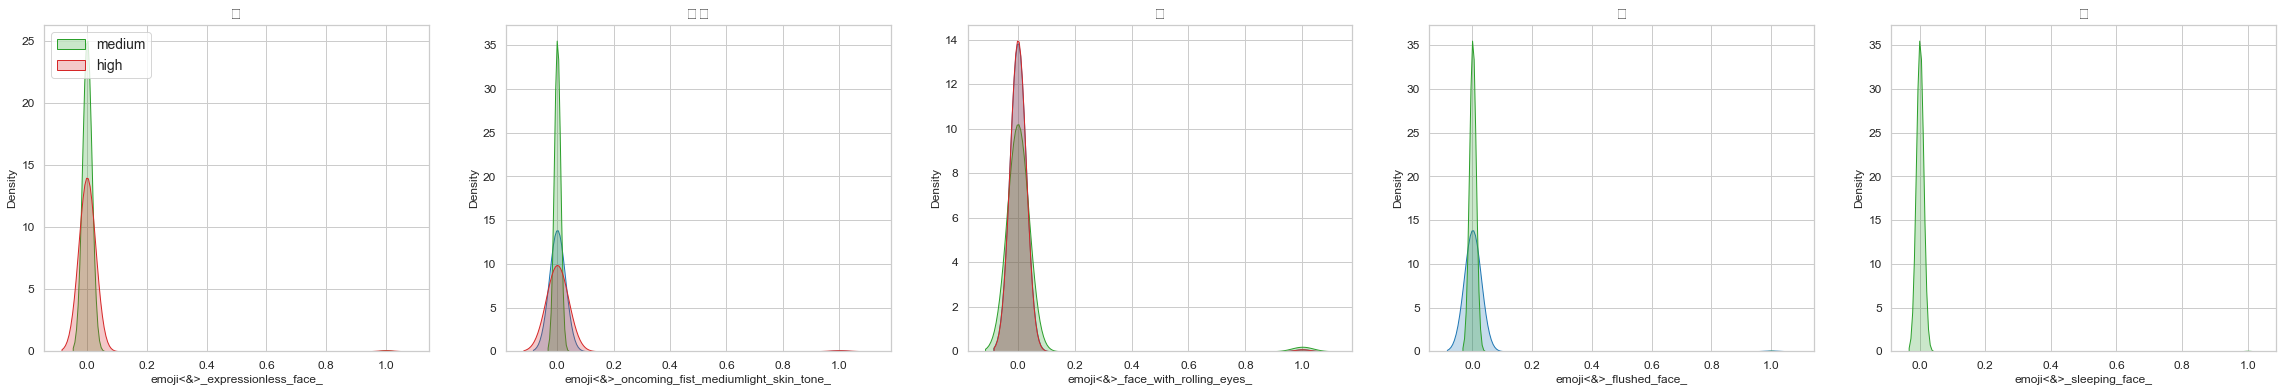

In [45]:
explorer = partition_attrib["emoji"][12:12+5]
colors_int = {"low": "tab:blue", "high": "tab:red", "medium": "tab:green"}
fig, ax = plt.subplots(1, len(explorer), figsize=(len(explorer)*8, 1*6))
for k, col in enumerate(explorer):      
    axi = ax[k]
    for int_ in intensities:
        _sub = df_representation[(df_train["sen"] == sen) & (df_train["int"] == int_)]
        sns.distplot(_sub[col], ax=axi , hist=False, kde_kws={"shade": True, "label": int_}, color=colors_int[int_])
        if "emoji<&>" in col:
            print(emojilib.emojize(col.replace("emoji<&>", "")))
            axi.set_title(emojilib.emojize(col.replace("emoji<&>", "")))
    if k == 0:
        axi.legend(loc='upper left')

In [ ]:
emojilib.emojize("_hugging_face_")

In [46]:
df_describe_cols = df_representation.describe().T

In [47]:
df_describe_cols.shape

(11750, 8)

In [48]:
rel_cols = list(df_describe_cols[df_describe_cols["std"]>[0.0762, 0.0710, 0.0635, 0.0573, 0.0527, 0.0503, 0.0477, 0.0390, 0.0318, 0.0276, 0.0225, 0.0159][0]].index)

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [52]:
indexs = df_train[df_train["sen"] == sentiments[3]].index
X = df_representation.loc[indexs][rel_cols]
y = df_train.loc[X.index]["int"]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight="balanced"))
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5232558139534884

In [9]:
from sklearn.feature_selection import SelectKBest, chi2

In [ ]:
indexs = df_train[df_train["sen"] == sentiments[3]].index
indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

X = df_representation.loc[indexsLH]#[rel_cols]
y = df_train.loc[X.index]["int"]

dic_label_count = y.value_counts().to_dict()
min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
index_label_1 = y[y==min_label].index
oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1
X_res, y_res = X.copy(), y.copy()

for step in range(oversampling_steps):
    new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
    copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
    copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
    X_res = pd.concat([X_res, copied_sub_X], axis=0)
    y_res = pd.concat([y_res, copied_sub_y], axis=0)

X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
selector = SelectKBest(chi2, k=X.shape[1])
X_res_ = X_res - X_res.min()
selector.fit(X_res_, y_res)
scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda y: y[1], reverse=True)]
ranked_cols


In [20]:
indexs = df_train[df_train["sen"] == sentiments[3]].index
scores_selector = {col: [] for col in df_representation.columns.tolist()}
comp_l = [(l1, l2) for l1 in intensities for l2 in intensities if l1 < l2]
for l1 in intensities:
    for l2 in intensities:
        if l1 < l2:
            indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin([l1, l2]))].index

            X = df_representation.loc[indexsLH]#[rel_cols]
            y = df_train.loc[X.index]["int"]

            dic_label_count = y.value_counts().to_dict()
            min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
            max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
            index_label_1 = y[y==min_label].index
            oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1
            X_res, y_res = X.copy(), y.copy()

            for step in range(oversampling_steps):
                new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
                copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
                copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
                X_res = pd.concat([X_res, copied_sub_X], axis=0)
                y_res = pd.concat([y_res, copied_sub_y], axis=0)

            X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
            selector = SelectKBest(chi2, k=X.shape[1])
            X_res_ = X_res - X_res.min()
            selector.fit(X_res_, y_res)
            for i, col in enumerate(X.columns.tolist()):
                scores_selector[col] += [selector.scores_[i]] if str(selector.scores_[i]) != "nan" else [0]

ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda y: max(y[1]), reverse=True)]
comp_l, ranked_cols

In [28]:
ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda y: max(y[1]), reverse=True)]
comp_l, ranked_cols

([('low', 'medium'), ('high', 'low'), ('high', 'medium')],
 ['linguistics<&>lemma<&>depress',
  'linguistics<&>lemma<&>depressing',
  'linguistics<&>lemma<&>grim',
  'linguistics<&>lemma<&>depression',
  'linguistics<&>lemma<&>sadness',
  'linguistics<&>lemma<&>honestly',
  'linguistics<&>lemma<&>️',
  'linguistics<&>shape<&>️',
  'linguistics<&>tag<&>-RRB-',
  'linguistics<&>lemma<&>frown',
  'linguistics<&>lemma<&>)',
  'linguistics<&>shape<&>)',
  'linguistics<&>tag<&>-LRB-',
  'linguistics<&>lemma<&>either',
  'linguistics<&>lemma<&>sadly',
  'linguistics<&>lemma<&>true',
  'linguistics<&>lemma<&>(',
  'linguistics<&>shape<&>(',
  'linguistics<&>lemma<&>something',
  'linguistics<&>lemma<&>sad',
  'linguistics<&>lemma<&>blue',
  'emoji<&>_face_with_tears_of_joy_',
  'linguistics<&>lemma<&>soul',
  'linguistics<&>lemma<&>fucking',
  'linguistics<&>lemma<&>tired',
  'emoji<&>_disappointed_face_',
  'linguistics<&>lemma<&>😞',
  'linguistics<&>shape<&>😞',
  'linguistics<&>lemma<&>body'

In [23]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support

In [50]:
sen = sentiments[0]

# indexs = df_train[df_train["sen"] == sen].index
# indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

# X = df_representation.loc[indexsLH]#[rel_cols]
# y = df_train.loc[X.index]["int"]

# dic_label_count = y.value_counts().to_dict()
# min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
# max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
# index_label_1 = y[y==min_label].index
# oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1
# X_res, y_res = X.copy(), y.copy()

# for step in range(oversampling_steps):
#     new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
#     copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
#     copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
#     X_res = pd.concat([X_res, copied_sub_X], axis=0)
#     y_res = pd.concat([y_res, copied_sub_y], axis=0)

# X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
# selector = SelectKBest(chi2, k=X.shape[1])
# X_res_ = X_res - X_res.min()
# selector.fit(X_res_, y_res)
# scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
# ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda x: x[1], reverse=True)]
# ranked_cols

indexs = df_train[df_train["sen"] == sen].index
scores_selector = {col: [] for col in df_representation.columns.tolist()}
comp_l = [(l1, l2) for l1 in intensities for l2 in intensities if l1 < l2]
for l1 in intensities:
    for l2 in intensities:
        if l1 < l2:
            indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin([l1, l2]))].index

            X = df_representation.loc[indexsLH]#[rel_cols]
            y = df_train.loc[X.index]["int"]

            dic_label_count = y.value_counts().to_dict()
            min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
            max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
            index_label_1 = y[y==min_label].index
            oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1
            X_res, y_res = X.copy(), y.copy()

            for step in range(oversampling_steps):
                new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
                copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
                copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
                X_res = pd.concat([X_res, copied_sub_X], axis=0)
                y_res = pd.concat([y_res, copied_sub_y], axis=0)

            X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
            selector = SelectKBest(chi2, k=X.shape[1])
            X_res_ = X_res - X_res.min()
            selector.fit(X_res_, y_res)
            for i, col in enumerate(X.columns.tolist()):
                scores_selector[col] += [selector.scores_[i]] if str(selector.scores_[i]) != "nan" else [0]

ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda y: max(y[1]), reverse=True)]
# comp_l, ranked_cols

f1_weight = []

for num_cols in range(1, len(ranked_cols), 10):
    X = df_representation.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(f1_weight[-1])

[1, 0.10424886540056362, 0.019309878014991615]
[11, 0.6411688350633156, 0.029228674134960844]
[21, 0.6609119066959994, 0.02203836650268399]
[31, 0.6588559737273805, 0.012008818616047677]
[41, 0.66215257900806, 0.004897267596503262]
[51, 0.6819780207011394, 0.018291375701466977]
[61, 0.6891776153090093, 0.018405652049383794]
[71, 0.6948351734809612, 0.026925106785193546]
[81, 0.698515744491627, 0.030620007364956892]
[91, 0.6995012251275626, 0.029302400431879483]
[101, 0.7001325185391131, 0.029258873024053687]
[111, 0.7115093975305629, 0.02715503116164831]
[121, 0.710112986921863, 0.02801785329972967]
[131, 0.7000463757225261, 0.03418087393899213]
[141, 0.7062307214260791, 0.03812506665278833]
[151, 0.7079706264171842, 0.03664070574426643]
[161, 0.7036688956016317, 0.038892980889282364]
[171, 0.7010408157744935, 0.04568406926917083]
[181, 0.6933352645072454, 0.032473129834692624]
[191, 0.6942896187745584, 0.04011906590259415]
[201, 0.6928814435108482, 0.043088935779638876]
[211, 0.686060

KeyboardInterrupt: 

In [51]:
best_f1 = sorted(f1_weight, key=lambda x: x[1], reverse=True)[0][0]
best_f1

721

In [52]:
fine_f1_weight = []

for num_cols in range(best_f1-10, best_f1+10, 1):
    X = df_representation.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    fine_f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(fine_f1_weight[-1])

[711, 0.7119090707998, 0.027855017461954637]
[712, 0.7136188549235528, 0.025519407164058552]
[713, 0.7136188549235528, 0.025519407164058552]
[714, 0.7136188549235528, 0.025519407164058552]
[715, 0.7147670371058765, 0.02471609889494386]
[716, 0.7152799717726143, 0.02237807015865809]
[717, 0.7152205637645912, 0.02236798949000108]
[718, 0.7152205637645912, 0.02236798949000108]
[719, 0.7152205637645912, 0.02236798949000108]
[720, 0.7139066277577931, 0.023421575299425103]
[721, 0.7139066277577931, 0.023421575299425103]
[722, 0.7130921410103506, 0.02330435003286564]
[723, 0.7130204092882748, 0.02329945517365635]
[724, 0.7130204092882748, 0.02329945517365635]
[725, 0.7130204092882748, 0.02329945517365635]
[726, 0.7138116315671187, 0.022539456984139863]
[727, 0.7138116315671187, 0.022539456984139863]
[728, 0.7138116315671187, 0.022539456984139863]
[729, 0.7138116315671187, 0.022539456984139863]
[730, 0.7138116315671187, 0.022539456984139863]


In [53]:
fine_best_f1 = sorted(fine_f1_weight, key=lambda x: x[1], reverse=True)[0][0]
fine_best_f1#0.577

716

In [54]:
pickle.dump(ranked_cols[:fine_best_f1+1], open(f"cols_selected_{sen}_v1.pickle", "wb"))

In [56]:
sen = sentiments[0]
print(sen)
cols_selected_sen = pickle.load(open(f"cols_selected_{sen}_v3.pickle", "rb"))
print(len(cols_selected_sen))
cols_selected_sen

anger
953


['linguistics<&>lemma<&>fume',
 'linguistics<&>lemma<&>fuck',
 'linguistics<&>lemma<&>angry',
 'linguistics<&>lemma<&>snap',
 'linguistics<&>lemma<&>so',
 'linguistics<&>lemma<&>:',
 'linguistics<&>shape<&>:',
 "linguistics<&>lemma<&>'s",
 'linguistics<&>lemma<&>fucking',
 'linguistics<&>tag<&>JJR',
 'linguistics<&>lemma<&>well',
 'linguistics<&>lemma<&>relentless',
 'linguistics<&>lemma<&>frown',
 'linguistics<&>lemma<&>wtf',
 'linguistics<&>lemma<&>irritate',
 'linguistics<&>lemma<&>boil',
 'linguistics<&>lemma<&>incense',
 'linguistics<&>lemma<&>piss',
 'linguistics<&>lemma<&>blood',
 'linguistics<&>lemma<&>again',
 'linguistics<&>lemma<&>then',
 'emoji<&>_pouting_face_',
 'linguistics<&>lemma<&>outrage',
 'linguistics<&>lemma<&>why',
 'linguistics<&>lemma<&>right',
 'linguistics<&>lemma<&>offense',
 'linguistics<&>lemma<&>laugh',
 'linguistics<&>lemma<&>pic',
 'linguistics<&>lemma<&>burst',
 'linguistics<&>lemma<&>shoot',
 'linguistics<&>lemma<&>move',
 'linguistics<&>lemma<&>hell'

In [54]:
!pip install torchvision

In [55]:
!pip install transformers

In [29]:
import torch
from transformers import AutoModel, AutoTokenizer

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

# For transformers v4.x+:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)

# For transformers v3.x:
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [30]:
data_bertweet = []
col_names = [f"BERTweet_{i}" for i in range(768)]
for k, ix in enumerate(df_train.index):
    print(k+1, df_train.shape[0], 100*(k+1)/df_train.shape[0])
    tweet = df_train.loc[ix]["text"]
    input_ids = torch.tensor([tokenizer.encode(tweet)])
    with torch.no_grad():
        outputs = bertweet(input_ids)
        hidden_states = outputs[0]

    token_embeddings = np.array([ll.numpy() for ll in hidden_states[0]])
    sentence_embedding = np.mean(token_embeddings, axis=0)
    o = {"id": ix}
    o = {**o, **dict(zip(col_names, sentence_embedding))}
    data_bertweet.append(o)

1 3960 0.025252525252525252
2 3960 0.050505050505050504
3 3960 0.07575757575757576
4 3960 0.10101010101010101
5 3960 0.12626262626262627
6 3960 0.15151515151515152
7 3960 0.17676767676767677
8 3960 0.20202020202020202
9 3960 0.22727272727272727
10 3960 0.25252525252525254
11 3960 0.2777777777777778
12 3960 0.30303030303030304
13 3960 0.3282828282828283
14 3960 0.35353535353535354
15 3960 0.3787878787878788
16 3960 0.40404040404040403
17 3960 0.4292929292929293
18 3960 0.45454545454545453
19 3960 0.4797979797979798
20 3960 0.5050505050505051
21 3960 0.5303030303030303
22 3960 0.5555555555555556
23 3960 0.5808080808080808
24 3960 0.6060606060606061
25 3960 0.6313131313131313
26 3960 0.6565656565656566
27 3960 0.6818181818181818
28 3960 0.7070707070707071
29 3960 0.7323232323232324
30 3960 0.7575757575757576
31 3960 0.7828282828282829
32 3960 0.8080808080808081
33 3960 0.8333333333333334
34 3960 0.8585858585858586
35 3960 0.8838383838383839
36 3960 0.9090909090909091
37 3960 0.93434343434

307 3960 7.752525252525253
308 3960 7.777777777777778
309 3960 7.803030303030303
310 3960 7.828282828282828
311 3960 7.853535353535354
312 3960 7.878787878787879
313 3960 7.904040404040404
314 3960 7.929292929292929
315 3960 7.954545454545454
316 3960 7.97979797979798
317 3960 8.005050505050505
318 3960 8.030303030303031
319 3960 8.055555555555555
320 3960 8.080808080808081
321 3960 8.106060606060606
322 3960 8.131313131313131
323 3960 8.156565656565656
324 3960 8.181818181818182
325 3960 8.207070707070708
326 3960 8.232323232323232
327 3960 8.257575757575758
328 3960 8.282828282828282
329 3960 8.308080808080808
330 3960 8.333333333333334
331 3960 8.358585858585858
332 3960 8.383838383838384
333 3960 8.409090909090908
334 3960 8.434343434343434
335 3960 8.45959595959596
336 3960 8.484848484848484
337 3960 8.51010101010101
338 3960 8.535353535353535
339 3960 8.56060606060606
340 3960 8.585858585858587
341 3960 8.61111111111111
342 3960 8.636363636363637
343 3960 8.66161616161616
344 396

609 3960 15.378787878787879
610 3960 15.404040404040405
611 3960 15.429292929292929
612 3960 15.454545454545455
613 3960 15.47979797979798
614 3960 15.505050505050505
615 3960 15.530303030303031
616 3960 15.555555555555555
617 3960 15.580808080808081
618 3960 15.606060606060606
619 3960 15.631313131313131
620 3960 15.656565656565656
621 3960 15.681818181818182
622 3960 15.707070707070708
623 3960 15.732323232323232
624 3960 15.757575757575758
625 3960 15.782828282828282
626 3960 15.808080808080808
627 3960 15.833333333333334
628 3960 15.858585858585858
629 3960 15.883838383838384
630 3960 15.909090909090908
631 3960 15.934343434343434
632 3960 15.95959595959596
633 3960 15.984848484848484
634 3960 16.01010101010101
635 3960 16.035353535353536
636 3960 16.060606060606062
637 3960 16.085858585858585
638 3960 16.11111111111111
639 3960 16.136363636363637
640 3960 16.161616161616163
641 3960 16.18686868686869
642 3960 16.21212121212121
643 3960 16.237373737373737
644 3960 16.26262626262626

907 3960 22.904040404040405
908 3960 22.92929292929293
909 3960 22.954545454545453
910 3960 22.97979797979798
911 3960 23.005050505050505
912 3960 23.03030303030303
913 3960 23.055555555555557
914 3960 23.08080808080808
915 3960 23.106060606060606
916 3960 23.13131313131313
917 3960 23.156565656565657
918 3960 23.181818181818183
919 3960 23.207070707070706
920 3960 23.232323232323232
921 3960 23.257575757575758
922 3960 23.282828282828284
923 3960 23.30808080808081
924 3960 23.333333333333332
925 3960 23.358585858585858
926 3960 23.383838383838384
927 3960 23.40909090909091
928 3960 23.434343434343436
929 3960 23.45959595959596
930 3960 23.484848484848484
931 3960 23.51010101010101
932 3960 23.535353535353536
933 3960 23.560606060606062
934 3960 23.585858585858585
935 3960 23.61111111111111
936 3960 23.636363636363637
937 3960 23.661616161616163
938 3960 23.68686868686869
939 3960 23.71212121212121
940 3960 23.737373737373737
941 3960 23.762626262626263
942 3960 23.78787878787879
943 3

1199 3960 30.27777777777778
1200 3960 30.303030303030305
1201 3960 30.328282828282827
1202 3960 30.353535353535353
1203 3960 30.37878787878788
1204 3960 30.404040404040405
1205 3960 30.42929292929293
1206 3960 30.454545454545453
1207 3960 30.47979797979798
1208 3960 30.505050505050505
1209 3960 30.53030303030303
1210 3960 30.555555555555557
1211 3960 30.58080808080808
1212 3960 30.606060606060606
1213 3960 30.63131313131313
1214 3960 30.656565656565657
1215 3960 30.681818181818183
1216 3960 30.707070707070706
1217 3960 30.732323232323232
1218 3960 30.757575757575758
1219 3960 30.782828282828284
1220 3960 30.80808080808081
1221 3960 30.833333333333332
1222 3960 30.858585858585858
1223 3960 30.883838383838384
1224 3960 30.90909090909091
1225 3960 30.934343434343436
1226 3960 30.95959595959596
1227 3960 30.984848484848484
1228 3960 31.01010101010101
1229 3960 31.035353535353536
1230 3960 31.060606060606062
1231 3960 31.085858585858585
1232 3960 31.11111111111111
1233 3960 31.1363636363636

1492 3960 37.676767676767675
1493 3960 37.7020202020202
1494 3960 37.72727272727273
1495 3960 37.75252525252525
1496 3960 37.77777777777778
1497 3960 37.803030303030305
1498 3960 37.82828282828283
1499 3960 37.85353535353536
1500 3960 37.878787878787875
1501 3960 37.9040404040404
1502 3960 37.92929292929293
1503 3960 37.95454545454545
1504 3960 37.97979797979798
1505 3960 38.005050505050505
1506 3960 38.03030303030303
1507 3960 38.05555555555556
1508 3960 38.08080808080808
1509 3960 38.10606060606061
1510 3960 38.13131313131313
1511 3960 38.156565656565654
1512 3960 38.18181818181818
1513 3960 38.207070707070706
1514 3960 38.23232323232323
1515 3960 38.25757575757576
1516 3960 38.282828282828284
1517 3960 38.30808080808081
1518 3960 38.333333333333336
1519 3960 38.35858585858586
1520 3960 38.38383838383838
1521 3960 38.40909090909091
1522 3960 38.43434343434343
1523 3960 38.45959595959596
1524 3960 38.484848484848484
1525 3960 38.51010101010101
1526 3960 38.535353535353536
1527 3960 38

1786 3960 45.101010101010104
1787 3960 45.12626262626262
1788 3960 45.15151515151515
1789 3960 45.176767676767675
1790 3960 45.2020202020202
1791 3960 45.22727272727273
1792 3960 45.25252525252525
1793 3960 45.27777777777778
1794 3960 45.303030303030305
1795 3960 45.32828282828283
1796 3960 45.35353535353536
1797 3960 45.378787878787875
1798 3960 45.4040404040404
1799 3960 45.42929292929293
1800 3960 45.45454545454545
1801 3960 45.47979797979798
1802 3960 45.505050505050505
1803 3960 45.53030303030303
1804 3960 45.55555555555556
1805 3960 45.58080808080808
1806 3960 45.60606060606061
1807 3960 45.63131313131313
1808 3960 45.656565656565654
1809 3960 45.68181818181818
1810 3960 45.707070707070706
1811 3960 45.73232323232323
1812 3960 45.75757575757576
1813 3960 45.782828282828284
1814 3960 45.80808080808081
1815 3960 45.833333333333336
1816 3960 45.85858585858586
1817 3960 45.88383838383838
1818 3960 45.90909090909091
1819 3960 45.93434343434343
1820 3960 45.95959595959596
1821 3960 45.

2078 3960 52.474747474747474
2079 3960 52.5
2080 3960 52.525252525252526
2081 3960 52.55050505050505
2082 3960 52.57575757575758
2083 3960 52.601010101010104
2084 3960 52.62626262626262
2085 3960 52.65151515151515
2086 3960 52.676767676767675
2087 3960 52.7020202020202
2088 3960 52.72727272727273
2089 3960 52.75252525252525
2090 3960 52.77777777777778
2091 3960 52.803030303030305
2092 3960 52.82828282828283
2093 3960 52.85353535353536
2094 3960 52.878787878787875
2095 3960 52.9040404040404
2096 3960 52.92929292929293
2097 3960 52.95454545454545
2098 3960 52.97979797979798
2099 3960 53.005050505050505
2100 3960 53.03030303030303
2101 3960 53.05555555555556
2102 3960 53.08080808080808
2103 3960 53.10606060606061
2104 3960 53.13131313131313
2105 3960 53.156565656565654
2106 3960 53.18181818181818
2107 3960 53.207070707070706
2108 3960 53.23232323232323
2109 3960 53.25757575757576
2110 3960 53.282828282828284
2111 3960 53.30808080808081
2112 3960 53.333333333333336
2113 3960 53.35858585858

2373 3960 59.92424242424242
2374 3960 59.94949494949495
2375 3960 59.974747474747474
2376 3960 60.0
2377 3960 60.025252525252526
2378 3960 60.05050505050505
2379 3960 60.07575757575758
2380 3960 60.101010101010104
2381 3960 60.12626262626262
2382 3960 60.15151515151515
2383 3960 60.176767676767675
2384 3960 60.2020202020202
2385 3960 60.22727272727273
2386 3960 60.25252525252525
2387 3960 60.27777777777778
2388 3960 60.303030303030305
2389 3960 60.32828282828283
2390 3960 60.35353535353536
2391 3960 60.378787878787875
2392 3960 60.4040404040404
2393 3960 60.42929292929293
2394 3960 60.45454545454545
2395 3960 60.47979797979798
2396 3960 60.505050505050505
2397 3960 60.53030303030303
2398 3960 60.55555555555556
2399 3960 60.58080808080808
2400 3960 60.60606060606061
2401 3960 60.63131313131313
2402 3960 60.656565656565654
2403 3960 60.68181818181818
2404 3960 60.707070707070706
2405 3960 60.73232323232323
2406 3960 60.75757575757576
2407 3960 60.782828282828284
2408 3960 60.808080808080

2670 3960 67.42424242424242
2671 3960 67.44949494949495
2672 3960 67.47474747474747
2673 3960 67.5
2674 3960 67.52525252525253
2675 3960 67.55050505050505
2676 3960 67.57575757575758
2677 3960 67.6010101010101
2678 3960 67.62626262626263
2679 3960 67.65151515151516
2680 3960 67.67676767676768
2681 3960 67.70202020202021
2682 3960 67.72727272727273
2683 3960 67.75252525252525
2684 3960 67.77777777777777
2685 3960 67.8030303030303
2686 3960 67.82828282828282
2687 3960 67.85353535353535
2688 3960 67.87878787878788
2689 3960 67.9040404040404
2690 3960 67.92929292929293
2691 3960 67.95454545454545
2692 3960 67.97979797979798
2693 3960 68.0050505050505
2694 3960 68.03030303030303
2695 3960 68.05555555555556
2696 3960 68.08080808080808
2697 3960 68.10606060606061
2698 3960 68.13131313131314
2699 3960 68.15656565656566
2700 3960 68.18181818181819
2701 3960 68.20707070707071
2702 3960 68.23232323232324
2703 3960 68.25757575757575
2704 3960 68.28282828282828
2705 3960 68.3080808080808
2706 3960 

2967 3960 74.92424242424242
2968 3960 74.94949494949495
2969 3960 74.97474747474747
2970 3960 75.0
2971 3960 75.02525252525253
2972 3960 75.05050505050505
2973 3960 75.07575757575758
2974 3960 75.1010101010101
2975 3960 75.12626262626263
2976 3960 75.15151515151516
2977 3960 75.17676767676768
2978 3960 75.20202020202021
2979 3960 75.22727272727273
2980 3960 75.25252525252525
2981 3960 75.27777777777777
2982 3960 75.3030303030303
2983 3960 75.32828282828282
2984 3960 75.35353535353535
2985 3960 75.37878787878788
2986 3960 75.4040404040404
2987 3960 75.42929292929293
2988 3960 75.45454545454545
2989 3960 75.47979797979798
2990 3960 75.5050505050505
2991 3960 75.53030303030303
2992 3960 75.55555555555556
2993 3960 75.58080808080808
2994 3960 75.60606060606061
2995 3960 75.63131313131314
2996 3960 75.65656565656566
2997 3960 75.68181818181819
2998 3960 75.70707070707071
2999 3960 75.73232323232324
3000 3960 75.75757575757575
3001 3960 75.78282828282828
3002 3960 75.8080808080808
3003 3960 

3264 3960 82.42424242424242
3265 3960 82.44949494949495
3266 3960 82.47474747474747
3267 3960 82.5
3268 3960 82.52525252525253
3269 3960 82.55050505050505
3270 3960 82.57575757575758
3271 3960 82.6010101010101
3272 3960 82.62626262626263
3273 3960 82.65151515151516
3274 3960 82.67676767676768
3275 3960 82.70202020202021
3276 3960 82.72727272727273
3277 3960 82.75252525252525
3278 3960 82.77777777777777
3279 3960 82.8030303030303
3280 3960 82.82828282828282
3281 3960 82.85353535353535
3282 3960 82.87878787878788
3283 3960 82.9040404040404
3284 3960 82.92929292929293
3285 3960 82.95454545454545
3286 3960 82.97979797979798
3287 3960 83.0050505050505
3288 3960 83.03030303030303
3289 3960 83.05555555555556
3290 3960 83.08080808080808
3291 3960 83.10606060606061
3292 3960 83.13131313131314
3293 3960 83.15656565656566
3294 3960 83.18181818181819
3295 3960 83.20707070707071
3296 3960 83.23232323232324
3297 3960 83.25757575757575
3298 3960 83.28282828282828
3299 3960 83.3080808080808
3300 3960 

3560 3960 89.8989898989899
3561 3960 89.92424242424242
3562 3960 89.94949494949495
3563 3960 89.97474747474747
3564 3960 90.0
3565 3960 90.02525252525253
3566 3960 90.05050505050505
3567 3960 90.07575757575758
3568 3960 90.1010101010101
3569 3960 90.12626262626263
3570 3960 90.15151515151516
3571 3960 90.17676767676768
3572 3960 90.20202020202021
3573 3960 90.22727272727273
3574 3960 90.25252525252525
3575 3960 90.27777777777777
3576 3960 90.3030303030303
3577 3960 90.32828282828282
3578 3960 90.35353535353535
3579 3960 90.37878787878788
3580 3960 90.4040404040404
3581 3960 90.42929292929293
3582 3960 90.45454545454545
3583 3960 90.47979797979798
3584 3960 90.5050505050505
3585 3960 90.53030303030303
3586 3960 90.55555555555556
3587 3960 90.58080808080808
3588 3960 90.60606060606061
3589 3960 90.63131313131314
3590 3960 90.65656565656566
3591 3960 90.68181818181819
3592 3960 90.70707070707071
3593 3960 90.73232323232324
3594 3960 90.75757575757575
3595 3960 90.78282828282828
3596 3960 

3856 3960 97.37373737373737
3857 3960 97.3989898989899
3858 3960 97.42424242424242
3859 3960 97.44949494949495
3860 3960 97.47474747474747
3861 3960 97.5
3862 3960 97.52525252525253
3863 3960 97.55050505050505
3864 3960 97.57575757575758
3865 3960 97.6010101010101
3866 3960 97.62626262626263
3867 3960 97.65151515151516
3868 3960 97.67676767676768
3869 3960 97.70202020202021
3870 3960 97.72727272727273
3871 3960 97.75252525252525
3872 3960 97.77777777777777
3873 3960 97.8030303030303
3874 3960 97.82828282828282
3875 3960 97.85353535353535
3876 3960 97.87878787878788
3877 3960 97.9040404040404
3878 3960 97.92929292929293
3879 3960 97.95454545454545
3880 3960 97.97979797979798
3881 3960 98.0050505050505
3882 3960 98.03030303030303
3883 3960 98.05555555555556
3884 3960 98.08080808080808
3885 3960 98.10606060606061
3886 3960 98.13131313131314
3887 3960 98.15656565656566
3888 3960 98.18181818181819
3889 3960 98.20707070707071
3890 3960 98.23232323232324
3891 3960 98.25757575757575
3892 3960 

In [31]:
# pickle.dump(pd.DataFrame(data_bertweet).set_index("id"), open("df_representation_v2.pickle", "wb"))

In [57]:
df_representation_v2 = pickle.load(open("df_representation_v2.pickle", "rb"))

In [58]:
df_representation_v2

,BERTweet_0,BERTweet_1,BERTweet_2,BERTweet_3,BERTweet_4,BERTweet_5,BERTweet_6,BERTweet_7,BERTweet_8,BERTweet_9,...,BERTweet_758,BERTweet_759,BERTweet_760,BERTweet_761,BERTweet_762,BERTweet_763,BERTweet_764,BERTweet_765,BERTweet_766,BERTweet_767
id,,,,,,,,,,,,,,,,,,,,,
10000,0.011935,-0.122075,0.029030,0.120095,0.093651,0.022820,0.006946,0.168774,0.282526,-0.009636,...,0.091612,0.013699,0.048113,0.180316,0.025295,-0.094723,0.094302,-0.039285,0.234481,-0.249347
10001,0.019873,-0.154840,0.128666,-0.013688,0.124787,-0.060633,0.029985,0.192368,0.358541,-0.000735,...,0.061139,0.057788,0.016066,0.114631,-0.075937,0.161129,0.088782,0.099523,0.195573,-0.094360
10002,0.089303,0.005199,0.056339,0.029113,0.114146,0.105520,0.041722,0.180096,0.075384,0.047837,...,0.058741,-0.221301,0.011673,0.277279,0.015945,0.010225,0.090561,0.177221,0.102671,-0.183728
10003,-0.174818,-0.169233,0.108006,0.089053,0.113685,-0.024810,0.045306,0.109823,0.190615,-0.004136,...,0.041260,0.074323,0.122148,0.129413,0.010133,-0.035607,0.095457,0.020883,0.222822,-0.049975
10004,0.016567,-0.013723,0.086389,-0.020837,0.122210,0.105154,0.083129,0.222264,0.327119,0.121932,...,0.152741,-0.128246,0.041543,0.219807,0.010124,0.019276,0.062688,0.044342,0.058079,-0.121317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40855,0.025625,-0.161436,0.085601,0.067647,0.092613,0.041396,0.085973,0.192643,0.252361,-0.007928,...,0.094263,0.087653,-0.054003,-0.014100,-0.015075,0.043808,0.258219,-0.013177,0.014293,0.006944
40856,-0.107447,0.002433,0.046188,0.105640,0.028643,0.141425,-0.002773,0.256521,0.372382,0.066727,...,0.090047,-0.136675,-0.018746,-0.072087,0.148523,-0.059273,0.200686,0.004628,0.182843,-0.168076
40857,-0.043438,0.011180,0.206375,0.071783,0.163780,-0.062001,-0.111886,0.200515,0.215893,0.117610,...,0.214575,-0.152968,-0.036713,0.054679,-0.097778,-0.037324,0.141307,0.059210,0.080930,-0.205299


In [85]:
sen = sentiments[3]

# indexs = df_train[df_train["sen"] == sen].index
# indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

# X = df_representation_v2.loc[indexsLH]#[rel_cols]
# y = df_train.loc[X.index]["int"]

# dic_label_count = y.value_counts().to_dict()
# min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
# max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
# index_label_1 = y[y==min_label].index
# oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1

# X_res, y_res = X.copy(), y.copy()
# for step in range(oversampling_steps):
#     new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
#     copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
#     copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
#     X_res = pd.concat([X_res, copied_sub_X], axis=0)
#     y_res = pd.concat([y_res, copied_sub_y], axis=0)

# X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
# selector = SelectKBest(chi2, k=X.shape[1])
# X_res_ = X_res - X_res.min()
# selector.fit(X_res_, y_res)
# scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
# ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda x: x[1], reverse=True)]
# print(ranked_cols)

indexs = df_train[df_train["sen"] == sen].index
scores_selector = {col: [] for col in df_representation_v2.columns.tolist()}
comp_l = [(l1, l2) for l1 in intensities for l2 in intensities if l1 < l2]
for l1 in intensities:
    for l2 in intensities:
        if l1 < l2:
            indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin([l1, l2]))].index

            X = df_representation_v2.loc[indexsLH]#[rel_cols]
            y = df_train.loc[X.index]["int"]

            dic_label_count = y.value_counts().to_dict()
            min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
            max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
            index_label_1 = y[y==min_label].index
            oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1
            X_res, y_res = X.copy(), y.copy()

            for step in range(oversampling_steps):
                new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
                copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
                copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
                X_res = pd.concat([X_res, copied_sub_X], axis=0)
                y_res = pd.concat([y_res, copied_sub_y], axis=0)

            X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
            selector = SelectKBest(chi2, k=X.shape[1])
            X_res_ = X_res - X_res.min()
            selector.fit(X_res_, y_res)
            for i, col in enumerate(X.columns.tolist()):
                scores_selector[col] += [selector.scores_[i]] if str(selector.scores_[i]) != "nan" else [0]

ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda y: max(y[1]), reverse=True)]

f1_weight = []

for num_cols in range(1, len(ranked_cols)+1, 10):
    X = df_representation_v2.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(f1_weight[-1])

[1, 0.4266742580862261, 0.029000652362772134]
[11, 0.5117476531712855, 0.019080276048811858]
[21, 0.5691244234970079, 0.04990272605701973]
[31, 0.595363860354104, 0.06558170336976499]
[41, 0.6146930984747271, 0.0577397523311529]
[51, 0.6061797724110066, 0.051271561695346364]
[61, 0.6217853427952491, 0.05838768871150769]
[71, 0.6232044194188641, 0.05301549697307111]
[81, 0.6214658103794599, 0.05771478690843295]
[91, 0.624423847601709, 0.044536946833991856]
[101, 0.6262091752425574, 0.028067527409609536]
[111, 0.6185092326001929, 0.036389237557653296]
[121, 0.6235964982309857, 0.03725058865965338]
[131, 0.6284264570252145, 0.03253518489236862]
[141, 0.6195900873245852, 0.0296541695143281]
[151, 0.617291930346149, 0.03715468479851581]
[161, 0.6260251365223966, 0.03725010209419756]
[171, 0.6226468402527421, 0.045070654836315664]
[181, 0.608469030245583, 0.053909784873922874]
[191, 0.6115024692531071, 0.053040255651115885]
[201, 0.6024820168684965, 0.053295301481507115]
[211, 0.610737709918

In [86]:
best_f1 = sorted(f1_weight, key=lambda x: x[1], reverse=True)[0][0]
best_f1

231

In [87]:
fine_f1_weight = []

for num_cols in range(best_f1-10, best_f1+10, 1):
    X = df_representation_v2.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    fine_f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(fine_f1_weight[-1])

[221, 0.6161255963718444, 0.03959949641766339]
[222, 0.6186198803002875, 0.036407568095489805]
[223, 0.6138463310886813, 0.043263347293339326]
[224, 0.6143611228959699, 0.03579301381324165]
[225, 0.6167498721827913, 0.03468169668907546]
[226, 0.622951465955635, 0.026664902471686684]
[227, 0.6229226948672073, 0.031095527637208215]
[228, 0.6239504164751969, 0.03321562044884642]
[229, 0.6255463082581119, 0.03356620439571124]
[230, 0.6327171768763874, 0.03932064083309087]
[231, 0.6339039135605046, 0.04073463436585979]
[232, 0.6327304831336775, 0.039429697311889514]
[233, 0.6327725983950642, 0.03841928757799965]
[234, 0.6269059225585256, 0.03663145007951668]
[235, 0.6259100504572533, 0.04273009908116228]
[236, 0.6268939376593157, 0.04169930241562819]
[237, 0.6262862090433599, 0.043669043514568004]
[238, 0.6265687269378318, 0.04438889611066611]
[239, 0.6304088107130051, 0.03911324370210424]
[240, 0.6292573854649839, 0.03802969201016805]


In [88]:
fine_best_f1 = sorted(fine_f1_weight, key=lambda x: x[1], reverse=True)[0][0]
fine_best_f1

231

In [84]:
pickle.dump(ranked_cols[:fine_best_f1+1], open(f"cols_selected_{sen}_v2.pickle", "wb"))

In [75]:
df_representation_v3 = df_representation
df_representation_v3 = pd.concat([df_representation_v3, df_representation_v2], axis=1)
df_representation_v3

,retro<&>num_tokens,retro<&>lenght,retro<&>num_numbs,retro<&>num_alpha,retro<&>num_with_uppercase,retro<&>num_tokens_upper,retro<&>prop_vowels,retro<&>len_max_rep_char,retro<&>max_char_fre_per_token(o),retro<&>max_char_fre_per_token(s),...,BERTweet_758,BERTweet_759,BERTweet_760,BERTweet_761,BERTweet_762,BERTweet_763,BERTweet_764,BERTweet_765,BERTweet_766,BERTweet_767
id,,,,,,,,,,,,,,,,,,,,,
10000,18,96,0,18,3,1,0.253165,2,2,1,...,0.091612,0.013699,0.048113,0.180316,0.025295,-0.094723,0.094302,-0.039285,0.234481,-0.249347
10001,23,119,0,25,7,2,0.329897,2,2,2,...,0.061139,0.057788,0.016066,0.114631,-0.075937,0.161129,0.088782,0.099523,0.195573,-0.094360
10002,19,108,0,19,2,2,0.333333,2,3,2,...,0.058741,-0.221301,0.011673,0.277279,0.015945,0.010225,0.090561,0.177221,0.102671,-0.183728
10003,24,134,0,23,1,1,0.315315,2,1,2,...,0.041260,0.074323,0.122148,0.129413,0.010133,-0.035607,0.095457,0.020883,0.222822,-0.049975
10004,24,125,0,25,3,0,0.352941,2,1,0,...,0.152741,-0.128246,0.041543,0.219807,0.010124,0.019276,0.062688,0.044342,0.058079,-0.121317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40855,24,112,0,23,2,1,0.325843,2,2,2,...,0.094263,0.087653,-0.054003,-0.014100,-0.015075,0.043808,0.258219,-0.013177,0.014293,0.006944
40856,20,121,0,21,1,0,0.352941,2,1,3,...,0.090047,-0.136675,-0.018746,-0.072087,0.148523,-0.059273,0.200686,0.004628,0.182843,-0.168076
40857,23,139,0,23,2,1,0.316239,2,2,4,...,0.214575,-0.152968,-0.036713,0.054679,-0.097778,-0.037324,0.141307,0.059210,0.080930,-0.205299


In [35]:
# pickle.dump(df_representation_v3, open("df_representation_v3.pickle", "wb"))

In [109]:
sen = sentiments[0]

# indexs = df_train[df_train["sen"] == sen].index
# indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

# X = df_representation_v3.loc[indexsLH]#[rel_cols]
# y = df_train.loc[X.index]["int"]

# dic_label_count = y.value_counts().to_dict()
# min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
# max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
# index_label_1 = y[y==min_label].index
# oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1

# X_res, y_res = X.copy(), y.copy()
# for step in range(oversampling_steps):
#     new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
#     copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
#     copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
#     X_res = pd.concat([X_res, copied_sub_X], axis=0)
#     y_res = pd.concat([y_res, copied_sub_y], axis=0)

# X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
# selector = SelectKBest(chi2, k=X.shape[1])
# X_res_ = X_res - X_res.min()
# selector.fit(X_res_, y_res)
# scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
# ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda x: x[1], reverse=True)]
# print(ranked_cols)

indexs = df_train[df_train["sen"] == sen].index
scores_selector = {col: [] for col in df_representation_v3.columns.tolist()}
comp_l = [(l1, l2) for l1 in intensities for l2 in intensities if l1 < l2]
for l1 in intensities:
    for l2 in intensities:
        if l1 < l2:
            indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin([l1, l2]))].index

            X = df_representation_v3.loc[indexsLH]#[rel_cols]
            y = df_train.loc[X.index]["int"]

            dic_label_count = y.value_counts().to_dict()
            min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
            max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
            index_label_1 = y[y==min_label].index
            oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1
            X_res, y_res = X.copy(), y.copy()

            for step in range(oversampling_steps):
                new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
                copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
                copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
                X_res = pd.concat([X_res, copied_sub_X], axis=0)
                y_res = pd.concat([y_res, copied_sub_y], axis=0)

            X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
            selector = SelectKBest(chi2, k=X.shape[1])
            X_res_ = X_res - X_res.min()
            selector.fit(X_res_, y_res)
            for i, col in enumerate(X.columns.tolist()):
                scores_selector[col] += [selector.scores_[i]] if str(selector.scores_[i]) != "nan" else [0]

ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda y: max(y[1]), reverse=True)]

f1_weight = []

for num_cols in range(1, len(ranked_cols)+1, 10):
    X = df_representation_v3.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(f1_weight[-1])

[1, 0.10424886540056362, 0.019309878014991615]
[11, 0.6411688350633156, 0.029228674134960844]
[21, 0.6609119066959994, 0.02203836650268399]
[31, 0.6588559737273805, 0.012008818616047677]
[41, 0.66215257900806, 0.004897267596503262]
[51, 0.6819780207011394, 0.018291375701466977]
[61, 0.6891776153090093, 0.018405652049383794]
[71, 0.6948351734809612, 0.026925106785193546]
[81, 0.698515744491627, 0.030620007364956892]
[91, 0.6995012251275626, 0.029302400431879483]
[101, 0.7001325185391131, 0.029258873024053687]
[111, 0.7115093975305629, 0.02715503116164831]
[121, 0.710112986921863, 0.02801785329972967]
[131, 0.7000463757225261, 0.03418087393899213]
[141, 0.7062307214260791, 0.03812506665278833]
[151, 0.7079706264171842, 0.03664070574426643]
[161, 0.7036688956016317, 0.038892980889282364]
[171, 0.7010408157744935, 0.04568406926917083]
[181, 0.6933352645072454, 0.032473129834692624]
[191, 0.6942896187745584, 0.04011906590259415]
[201, 0.6928814435108482, 0.043088935779638876]
[211, 0.686060

KeyboardInterrupt: 

In [110]:
best_f1 = sorted(f1_weight, key=lambda x: x[1], reverse=True)[0][0]
best_f1

721

In [111]:
fine_f1_weight = []

for num_cols in range(best_f1-10, best_f1+10, 1):
    X = df_representation_v3.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    fine_f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(fine_f1_weight[-1])

[711, 0.7119090707998, 0.027855017461954637]
[712, 0.7136188549235528, 0.025519407164058552]
[713, 0.7136188549235528, 0.025519407164058552]
[714, 0.7136188549235528, 0.025519407164058552]
[715, 0.7147670371058765, 0.02471609889494386]
[716, 0.7152799717726143, 0.02237807015865809]
[717, 0.7152205637645912, 0.02236798949000108]
[718, 0.7152205637645912, 0.02236798949000108]
[719, 0.7152205637645912, 0.02236798949000108]
[720, 0.7139066277577931, 0.023421575299425103]
[721, 0.7139066277577931, 0.023421575299425103]
[722, 0.7130921410103506, 0.02330435003286564]
[723, 0.7130204092882748, 0.02329945517365635]
[724, 0.7130204092882748, 0.02329945517365635]
[725, 0.7130204092882748, 0.02329945517365635]
[726, 0.7138116315671187, 0.022539456984139863]
[727, 0.7138116315671187, 0.022539456984139863]
[728, 0.7138116315671187, 0.022539456984139863]
[729, 0.7138116315671187, 0.022539456984139863]
[730, 0.7138116315671187, 0.022539456984139863]


In [112]:
fine_best_f1 = sorted(fine_f1_weight, key=lambda x: x[1], reverse=True)[0][0]
fine_best_f1

716

In [113]:
pickle.dump(ranked_cols[:fine_best_f1+1], open(f"cols_selected_{sen}_v3.pickle", "wb"))

In [36]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('opinion_lexicon')
# nltk.download("sentiwordnet")
# nltk.download('omw-1.4')

from nltk.corpus import opinion_lexicon
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [37]:
def get_sentiwordnet_sent(tweet):
    def penn_to_wn(tag):
        if tag.startswith('J'):
            return wn.ADJ
        elif tag.startswith('N'):
            return wn.NOUN
        elif tag.startswith('R'):
            return wn.ADV
        elif tag.startswith('V'):
            return wn.VERB
        return None

    def get_sentiment(word,tag):
        wn_tag = penn_to_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            return [0,0,0]

        lemma = lemmatizer.lemmatize(word, pos=wn_tag)
        if not lemma:
            return [0,0,0]

        synsets = wn.synsets(word, pos=wn_tag)
        if not synsets:
            return [0,0,0]

        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())

        return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    words_data = tweet.lower().strip().split()

    pos_val = nltk.pos_tag(words_data)
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    return dict(zip("+ - o".split(), np.sum(senti_val, axis=0)))

In [38]:
print(f"Cantidad de palabras positivas: {len(opinion_lexicon.positive())}")
print(f"Cantidad de palabras negativas: {len(opinion_lexicon.negative())}")

Cantidad de palabras positivas: 2006
Cantidad de palabras negativas: 4783


In [39]:
def get_lexicon_attrib(tweet):
    o = {}
    o["lexicon<&>LiuHu<&>+"] = sum(int(t.lower() in opinion_lexicon.positive()) for t in tweet.split())
    o["lexicon<&>LiuHu<&>-"] = sum(int(t.lower() in opinion_lexicon.negative()) for t in tweet.split())
    o_sentiwordnet = get_sentiwordnet_sent(tweet)
    o["lexicon<&>sentiwordnet<&>+"] = o_sentiwordnet["+"]
    o["lexicon<&>sentiwordnet<&>-"] = o_sentiwordnet["-"]
    o["lexicon<&>sentiwordnet<&>o"] = o_sentiwordnet["o"]
    return o

In [40]:
get_lexicon_attrib(tweet)

{'lexicon<&>LiuHu<&>+': 0,
 'lexicon<&>LiuHu<&>-': 6,
 'lexicon<&>sentiwordnet<&>+': 0.375,
 'lexicon<&>sentiwordnet<&>-': 3.5,
 'lexicon<&>sentiwordnet<&>o': 3.125}

In [41]:
data_lexicon_attributes = []
times = []
for k, ix in enumerate(df_train.index):
    start_time = time.time()
    tweet = df_train.loc[ix]["text"]
    o = {"id": ix}
    o = {**o, **get_lexicon_attrib(tweet)}
    data_lexicon_attributes.append(o)
    dt = time.time()-start_time
    times.append(dt)
    print(f"""
    row: {k+1}, total_rows: {df_train.shape[0]}
    progress: {np.round(100*(k+1)/df_train.shape[0], 3)}%
    wait time: {datetime.timedelta(seconds = np.median(times)*(df_train.shape[0]-k-1))}s
    """)


    row: 1, total_rows: 3960
    progress: 0.025%
    wait time: 0:14:39.696078s
    

    row: 2, total_rows: 3960
    progress: 0.051%
    wait time: 0:16:38.320869s
    

    row: 3, total_rows: 3960
    progress: 0.076%
    wait time: 0:15:34.698491s
    

    row: 4, total_rows: 3960
    progress: 0.101%
    wait time: 0:17:05.532814s
    

    row: 5, total_rows: 3960
    progress: 0.126%
    wait time: 0:18:36.321094s
    

    row: 6, total_rows: 3960
    progress: 0.152%
    wait time: 0:17:05.014344s
    

    row: 7, total_rows: 3960
    progress: 0.177%
    wait time: 0:18:35.756583s
    

    row: 8, total_rows: 3960
    progress: 0.202%
    wait time: 0:17:55.920444s
    

    row: 9, total_rows: 3960
    progress: 0.227%
    wait time: 0:17:16.104323s
    

    row: 10, total_rows: 3960
    progress: 0.253%
    wait time: 0:16:24.443539s
    

    row: 11, total_rows: 3960
    progress: 0.278%
    wait time: 0:15:32.808780s
    

    row: 12, total_rows: 3960
    progre


    row: 96, total_rows: 3960
    progress: 2.424%
    wait time: 0:13:47.645845s
    

    row: 97, total_rows: 3960
    progress: 2.449%
    wait time: 0:13:51.298055s
    

    row: 98, total_rows: 3960
    progress: 2.475%
    wait time: 0:14:04.612692s
    

    row: 99, total_rows: 3960
    progress: 2.5%
    wait time: 0:14:17.920323s
    

    row: 100, total_rows: 3960
    progress: 2.525%
    wait time: 0:14:04.175296s
    

    row: 101, total_rows: 3960
    progress: 2.551%
    wait time: 0:13:50.437276s
    

    row: 102, total_rows: 3960
    progress: 2.576%
    wait time: 0:13:46.360681s
    

    row: 103, total_rows: 3960
    progress: 2.601%
    wait time: 0:13:50.006886s
    

    row: 104, total_rows: 3960
    progress: 2.626%
    wait time: 0:13:45.932293s
    

    row: 105, total_rows: 3960
    progress: 2.652%
    wait time: 0:13:41.859702s
    

    row: 106, total_rows: 3960
    progress: 2.677%
    wait time: 0:13:45.503905s
    

    row: 107, total_rows: 


    row: 189, total_rows: 3960
    progress: 4.773%
    wait time: 0:12:46.206447s
    

    row: 190, total_rows: 3960
    progress: 4.798%
    wait time: 0:12:44.118849s
    

    row: 191, total_rows: 3960
    progress: 4.823%
    wait time: 0:12:45.800079s
    

    row: 192, total_rows: 3960
    progress: 4.848%
    wait time: 0:12:49.367766s
    

    row: 193, total_rows: 3960
    progress: 4.874%
    wait time: 0:12:45.393711s
    

    row: 194, total_rows: 3960
    progress: 4.899%
    wait time: 0:12:43.308113s
    

    row: 195, total_rows: 3960
    progress: 4.924%
    wait time: 0:12:41.223514s
    

    row: 196, total_rows: 3960
    progress: 4.949%
    wait time: 0:12:42.902745s
    

    row: 197, total_rows: 3960
    progress: 4.975%
    wait time: 0:12:44.580976s
    

    row: 198, total_rows: 3960
    progress: 5.0%
    wait time: 0:12:48.142658s
    

    row: 199, total_rows: 3960
    progress: 5.025%
    wait time: 0:12:51.702340s
    

    row: 200, total_ro


    row: 283, total_rows: 3960
    progress: 7.146%
    wait time: 0:12:49.191232s
    

    row: 284, total_rows: 3960
    progress: 7.172%
    wait time: 0:12:50.822100s
    

    row: 285, total_rows: 3960
    progress: 7.197%
    wait time: 0:12:48.772852s
    

    row: 286, total_rows: 3960
    progress: 7.222%
    wait time: 0:12:46.725044s
    

    row: 287, total_rows: 3960
    progress: 7.247%
    wait time: 0:12:48.354473s
    

    row: 288, total_rows: 3960
    progress: 7.273%
    wait time: 0:12:46.307665s
    

    row: 289, total_rows: 3960
    progress: 7.298%
    wait time: 0:12:47.936093s
    

    row: 290, total_rows: 3960
    progress: 7.323%
    wait time: 0:12:45.890286s
    

    row: 291, total_rows: 3960
    progress: 7.348%
    wait time: 0:12:47.517713s
    

    row: 292, total_rows: 3960
    progress: 7.374%
    wait time: 0:12:45.472907s
    

    row: 293, total_rows: 3960
    progress: 7.399%
    wait time: 0:12:47.099333s
    

    row: 294, total_


    row: 377, total_rows: 3960
    progress: 9.52%
    wait time: 0:12:00.840687s
    

    row: 378, total_rows: 3960
    progress: 9.545%
    wait time: 0:12:02.431654s
    

    row: 379, total_rows: 3960
    progress: 9.571%
    wait time: 0:12:00.438319s
    

    row: 380, total_rows: 3960
    progress: 9.596%
    wait time: 0:12:00.236282s
    

    row: 381, total_rows: 3960
    progress: 9.621%
    wait time: 0:12:00.035952s
    

    row: 382, total_rows: 3960
    progress: 9.646%
    wait time: 0:11:59.833916s
    

    row: 383, total_rows: 3960
    progress: 9.672%
    wait time: 0:11:59.631880s
    

    row: 384, total_rows: 3960
    progress: 9.697%
    wait time: 0:11:59.431549s
    

    row: 385, total_rows: 3960
    progress: 9.722%
    wait time: 0:11:59.229513s
    

    row: 386, total_rows: 3960
    progress: 9.747%
    wait time: 0:11:59.028330s
    

    row: 387, total_rows: 3960
    progress: 9.773%
    wait time: 0:11:58.827147s
    

    row: 388, total_r


    row: 470, total_rows: 3960
    progress: 11.869%
    wait time: 0:11:40.382414s
    

    row: 471, total_rows: 3960
    progress: 11.894%
    wait time: 0:11:41.925273s
    

    row: 472, total_rows: 3960
    progress: 11.919%
    wait time: 0:11:39.981049s
    

    row: 473, total_rows: 3960
    progress: 11.944%
    wait time: 0:11:41.522908s
    

    row: 474, total_rows: 3960
    progress: 11.97%
    wait time: 0:11:41.321726s
    

    row: 475, total_rows: 3960
    progress: 11.995%
    wait time: 0:11:41.120543s
    

    row: 476, total_rows: 3960
    progress: 12.02%
    wait time: 0:11:40.919361s
    

    row: 477, total_rows: 3960
    progress: 12.045%
    wait time: 0:11:40.718179s
    

    row: 478, total_rows: 3960
    progress: 12.071%
    wait time: 0:11:38.776953s
    

    row: 479, total_rows: 3960
    progress: 12.096%
    wait time: 0:11:40.315814s
    

    row: 480, total_rows: 3960
    progress: 12.121%
    wait time: 0:11:38.375587s
    

    row: 48


    row: 563, total_rows: 3960
    progress: 14.217%
    wait time: 0:11:23.416495s
    

    row: 564, total_rows: 3960
    progress: 14.242%
    wait time: 0:11:23.216527s
    

    row: 565, total_rows: 3960
    progress: 14.268%
    wait time: 0:11:23.014131s
    

    row: 566, total_rows: 3960
    progress: 14.293%
    wait time: 0:11:22.814162s
    

    row: 567, total_rows: 3960
    progress: 14.318%
    wait time: 0:11:22.611766s
    

    row: 568, total_rows: 3960
    progress: 14.343%
    wait time: 0:11:22.411797s
    

    row: 569, total_rows: 3960
    progress: 14.369%
    wait time: 0:11:22.211827s
    

    row: 570, total_rows: 3960
    progress: 14.394%
    wait time: 0:11:22.009431s
    

    row: 571, total_rows: 3960
    progress: 14.419%
    wait time: 0:11:21.809460s
    

    row: 572, total_rows: 3960
    progress: 14.444%
    wait time: 0:11:21.607066s
    

    row: 573, total_rows: 3960
    progress: 14.47%
    wait time: 0:11:21.404672s
    

    row: 5


    row: 656, total_rows: 3960
    progress: 16.566%
    wait time: 0:11:03.053867s
    

    row: 657, total_rows: 3960
    progress: 16.591%
    wait time: 0:11:01.204167s
    

    row: 658, total_rows: 3960
    progress: 16.616%
    wait time: 0:11:02.652503s
    

    row: 659, total_rows: 3960
    progress: 16.641%
    wait time: 0:11:04.099840s
    

    row: 660, total_rows: 3960
    progress: 16.667%
    wait time: 0:11:02.251139s
    

    row: 661, total_rows: 3960
    progress: 16.692%
    wait time: 0:11:03.697477s
    

    row: 662, total_rows: 3960
    progress: 16.717%
    wait time: 0:11:03.497869s
    

    row: 663, total_rows: 3960
    progress: 16.742%
    wait time: 0:11:03.298259s
    

    row: 664, total_rows: 3960
    progress: 16.768%
    wait time: 0:11:03.097076s
    

    row: 665, total_rows: 3960
    progress: 16.793%
    wait time: 0:11:02.895894s
    

    row: 666, total_rows: 3960
    progress: 16.818%
    wait time: 0:11:02.695890s
    

    row: 


    row: 749, total_rows: 3960
    progress: 18.914%
    wait time: 0:10:39.569682s
    

    row: 750, total_rows: 3960
    progress: 18.939%
    wait time: 0:10:39.370501s
    

    row: 751, total_rows: 3960
    progress: 18.965%
    wait time: 0:10:39.171320s
    

    row: 752, total_rows: 3960
    progress: 18.99%
    wait time: 0:10:38.972139s
    

    row: 753, total_rows: 3960
    progress: 19.015%
    wait time: 0:10:38.772959s
    

    row: 754, total_rows: 3960
    progress: 19.04%
    wait time: 0:10:38.573778s
    

    row: 755, total_rows: 3960
    progress: 19.066%
    wait time: 0:10:38.374597s
    

    row: 756, total_rows: 3960
    progress: 19.091%
    wait time: 0:10:36.688498s
    

    row: 757, total_rows: 3960
    progress: 19.116%
    wait time: 0:10:35.003327s
    

    row: 758, total_rows: 3960
    progress: 19.141%
    wait time: 0:10:36.291065s
    

    row: 759, total_rows: 3960
    progress: 19.167%
    wait time: 0:10:34.606822s
    

    row: 76


    row: 842, total_rows: 3960
    progress: 21.263%
    wait time: 0:10:00.762120s
    

    row: 843, total_rows: 3960
    progress: 21.288%
    wait time: 0:09:59.009199s
    

    row: 844, total_rows: 3960
    progress: 21.313%
    wait time: 0:10:00.376769s
    

    row: 845, total_rows: 3960
    progress: 21.338%
    wait time: 0:09:58.624849s
    

    row: 846, total_rows: 3960
    progress: 21.364%
    wait time: 0:09:59.991418s
    

    row: 847, total_rows: 3960
    progress: 21.389%
    wait time: 0:09:58.240499s
    

    row: 848, total_rows: 3960
    progress: 21.414%
    wait time: 0:09:58.047954s
    

    row: 849, total_rows: 3960
    progress: 21.439%
    wait time: 0:09:57.856150s
    

    row: 850, total_rows: 3960
    progress: 21.465%
    wait time: 0:09:57.663604s
    

    row: 851, total_rows: 3960
    progress: 21.49%
    wait time: 0:09:57.471059s
    

    row: 852, total_rows: 3960
    progress: 21.515%
    wait time: 0:09:57.277772s
    

    row: 8


    row: 934, total_rows: 3960
    progress: 23.586%
    wait time: 0:09:41.520921s
    

    row: 935, total_rows: 3960
    progress: 23.611%
    wait time: 0:09:41.329107s
    

    row: 936, total_rows: 3960
    progress: 23.636%
    wait time: 0:09:41.136572s
    

    row: 937, total_rows: 3960
    progress: 23.662%
    wait time: 0:09:40.944757s
    

    row: 938, total_rows: 3960
    progress: 23.687%
    wait time: 0:09:42.265274s
    

    row: 939, total_rows: 3960
    progress: 23.712%
    wait time: 0:09:40.560408s
    

    row: 940, total_rows: 3960
    progress: 23.737%
    wait time: 0:09:40.367873s
    

    row: 941, total_rows: 3960
    progress: 23.763%
    wait time: 0:09:40.175338s
    

    row: 942, total_rows: 3960
    progress: 23.788%
    wait time: 0:09:39.982084s
    

    row: 943, total_rows: 3960
    progress: 23.813%
    wait time: 0:09:39.788831s
    

    row: 944, total_rows: 3960
    progress: 23.838%
    wait time: 0:09:38.088047s
    

    row: 


    row: 1026, total_rows: 3960
    progress: 25.909%
    wait time: 0:09:23.840841s
    

    row: 1027, total_rows: 3960
    progress: 25.934%
    wait time: 0:09:23.648316s
    

    row: 1028, total_rows: 3960
    progress: 25.96%
    wait time: 0:09:23.456491s
    

    row: 1029, total_rows: 3960
    progress: 25.985%
    wait time: 0:09:23.263967s
    

    row: 1030, total_rows: 3960
    progress: 26.01%
    wait time: 0:09:23.071094s
    

    row: 1031, total_rows: 3960
    progress: 26.035%
    wait time: 0:09:22.878221s
    

    row: 1032, total_rows: 3960
    progress: 26.061%
    wait time: 0:09:22.686745s
    

    row: 1033, total_rows: 3960
    progress: 26.086%
    wait time: 0:09:22.493872s
    

    row: 1034, total_rows: 3960
    progress: 26.111%
    wait time: 0:09:22.302396s
    

    row: 1035, total_rows: 3960
    progress: 26.136%
    wait time: 0:09:22.110919s
    

    row: 1036, total_rows: 3960
    progress: 26.162%
    wait time: 0:09:21.919093s
    




    row: 1117, total_rows: 3960
    progress: 28.207%
    wait time: 0:09:09.210979s
    

    row: 1118, total_rows: 3960
    progress: 28.232%
    wait time: 0:09:09.012040s
    

    row: 1119, total_rows: 3960
    progress: 28.258%
    wait time: 0:09:08.813104s
    

    row: 1120, total_rows: 3960
    progress: 28.283%
    wait time: 0:09:08.625684s
    

    row: 1121, total_rows: 3960
    progress: 28.308%
    wait time: 0:09:08.438259s
    

    row: 1122, total_rows: 3960
    progress: 28.333%
    wait time: 0:09:08.239328s
    

    row: 1123, total_rows: 3960
    progress: 28.359%
    wait time: 0:09:08.040400s
    

    row: 1124, total_rows: 3960
    progress: 28.384%
    wait time: 0:09:07.852972s
    

    row: 1125, total_rows: 3960
    progress: 28.409%
    wait time: 0:09:07.665539s
    

    row: 1126, total_rows: 3960
    progress: 28.434%
    wait time: 0:09:08.882837s
    

    row: 1127, total_rows: 3960
    progress: 28.46%
    wait time: 0:09:10.099140s
    



    row: 1208, total_rows: 3960
    progress: 30.505%
    wait time: 0:08:59.882072s
    

    row: 1209, total_rows: 3960
    progress: 30.53%
    wait time: 0:08:59.685566s
    

    row: 1210, total_rows: 3960
    progress: 30.556%
    wait time: 0:08:59.489716s
    

    row: 1211, total_rows: 3960
    progress: 30.581%
    wait time: 0:08:59.293866s
    

    row: 1212, total_rows: 3960
    progress: 30.606%
    wait time: 0:08:59.098015s
    

    row: 1213, total_rows: 3960
    progress: 30.631%
    wait time: 0:08:58.902164s
    

    row: 1214, total_rows: 3960
    progress: 30.657%
    wait time: 0:08:58.705659s
    

    row: 1215, total_rows: 3960
    progress: 30.682%
    wait time: 0:08:58.509808s
    

    row: 1216, total_rows: 3960
    progress: 30.707%
    wait time: 0:08:58.313302s
    

    row: 1217, total_rows: 3960
    progress: 30.732%
    wait time: 0:08:58.116797s
    

    row: 1218, total_rows: 3960
    progress: 30.758%
    wait time: 0:08:57.920945s
    



    row: 1301, total_rows: 3960
    progress: 32.854%
    wait time: 0:08:44.297903s
    

    row: 1302, total_rows: 3960
    progress: 32.879%
    wait time: 0:08:44.101675s
    

    row: 1303, total_rows: 3960
    progress: 32.904%
    wait time: 0:08:43.903546s
    

    row: 1304, total_rows: 3960
    progress: 32.929%
    wait time: 0:08:43.705418s
    

    row: 1305, total_rows: 3960
    progress: 32.955%
    wait time: 0:08:43.509189s
    

    row: 1306, total_rows: 3960
    progress: 32.98%
    wait time: 0:08:43.311061s
    

    row: 1307, total_rows: 3960
    progress: 33.005%
    wait time: 0:08:43.114832s
    

    row: 1308, total_rows: 3960
    progress: 33.03%
    wait time: 0:08:42.916705s
    

    row: 1309, total_rows: 3960
    progress: 33.056%
    wait time: 0:08:42.718578s
    

    row: 1310, total_rows: 3960
    progress: 33.081%
    wait time: 0:08:41.787870s
    

    row: 1311, total_rows: 3960
    progress: 33.106%
    wait time: 0:08:42.324223s
    




    row: 1392, total_rows: 3960
    progress: 35.152%
    wait time: 0:08:28.925526s
    

    row: 1393, total_rows: 3960
    progress: 35.177%
    wait time: 0:08:28.727346s
    

    row: 1394, total_rows: 3960
    progress: 35.202%
    wait time: 0:08:28.529166s
    

    row: 1395, total_rows: 3960
    progress: 35.227%
    wait time: 0:08:28.330986s
    

    row: 1396, total_rows: 3960
    progress: 35.253%
    wait time: 0:08:28.132807s
    

    row: 1397, total_rows: 3960
    progress: 35.278%
    wait time: 0:08:27.934627s
    

    row: 1398, total_rows: 3960
    progress: 35.303%
    wait time: 0:08:27.736447s
    

    row: 1399, total_rows: 3960
    progress: 35.328%
    wait time: 0:08:27.538268s
    

    row: 1400, total_rows: 3960
    progress: 35.354%
    wait time: 0:08:27.339783s
    

    row: 1401, total_rows: 3960
    progress: 35.379%
    wait time: 0:08:27.141298s
    

    row: 1402, total_rows: 3960
    progress: 35.404%
    wait time: 0:08:26.943424s
    


    row: 1483, total_rows: 3960
    progress: 37.449%
    wait time: 0:08:10.891762s
    

    row: 1484, total_rows: 3960
    progress: 37.475%
    wait time: 0:08:10.693582s
    

    row: 1485, total_rows: 3960
    progress: 37.5%
    wait time: 0:08:10.495402s
    

    row: 1486, total_rows: 3960
    progress: 37.525%
    wait time: 0:08:10.296927s
    

    row: 1487, total_rows: 3960
    progress: 37.551%
    wait time: 0:08:10.099042s
    

    row: 1488, total_rows: 3960
    progress: 37.576%
    wait time: 0:08:09.900567s
    

    row: 1489, total_rows: 3960
    progress: 37.601%
    wait time: 0:08:09.702093s
    

    row: 1490, total_rows: 3960
    progress: 37.626%
    wait time: 0:08:09.503913s
    

    row: 1491, total_rows: 3960
    progress: 37.652%
    wait time: 0:08:09.305733s
    

    row: 1492, total_rows: 3960
    progress: 37.677%
    wait time: 0:08:09.107259s
    

    row: 1493, total_rows: 3960
    progress: 37.702%
    wait time: 0:08:08.908786s
    




    row: 1574, total_rows: 3960
    progress: 39.747%
    wait time: 0:07:52.856816s
    

    row: 1575, total_rows: 3960
    progress: 39.773%
    wait time: 0:07:52.658637s
    

    row: 1576, total_rows: 3960
    progress: 39.798%
    wait time: 0:07:52.460741s
    

    row: 1577, total_rows: 3960
    progress: 39.823%
    wait time: 0:07:52.262277s
    

    row: 1578, total_rows: 3960
    progress: 39.848%
    wait time: 0:07:52.064097s
    

    row: 1579, total_rows: 3960
    progress: 39.874%
    wait time: 0:07:51.865918s
    

    row: 1580, total_rows: 3960
    progress: 39.899%
    wait time: 0:07:51.668022s
    

    row: 1581, total_rows: 3960
    progress: 39.924%
    wait time: 0:07:51.469558s
    

    row: 1582, total_rows: 3960
    progress: 39.949%
    wait time: 0:07:51.271662s
    

    row: 1583, total_rows: 3960
    progress: 39.975%
    wait time: 0:07:51.073199s
    

    row: 1584, total_rows: 3960
    progress: 40.0%
    wait time: 0:07:50.875019s
    




    row: 1667, total_rows: 3960
    progress: 42.096%
    wait time: 0:07:34.427742s
    

    row: 1668, total_rows: 3960
    progress: 42.121%
    wait time: 0:07:34.229015s
    

    row: 1669, total_rows: 3960
    progress: 42.146%
    wait time: 0:07:34.031381s
    

    row: 1670, total_rows: 3960
    progress: 42.172%
    wait time: 0:07:33.832655s
    

    row: 1671, total_rows: 3960
    progress: 42.197%
    wait time: 0:07:33.633929s
    

    row: 1672, total_rows: 3960
    progress: 42.222%
    wait time: 0:07:33.436295s
    

    row: 1673, total_rows: 3960
    progress: 42.247%
    wait time: 0:07:33.238660s
    

    row: 1674, total_rows: 3960
    progress: 42.273%
    wait time: 0:07:33.042114s
    

    row: 1675, total_rows: 3960
    progress: 42.298%
    wait time: 0:07:32.845567s
    

    row: 1676, total_rows: 3960
    progress: 42.323%
    wait time: 0:07:32.728251s
    

    row: 1677, total_rows: 3960
    progress: 42.348%
    wait time: 0:07:32.449204s
    


    row: 1759, total_rows: 3960
    progress: 44.419%
    wait time: 0:07:18.397032s
    

    row: 1760, total_rows: 3960
    progress: 44.444%
    wait time: 0:07:18.197851s
    

    row: 1761, total_rows: 3960
    progress: 44.47%
    wait time: 0:07:17.998670s
    

    row: 1762, total_rows: 3960
    progress: 44.495%
    wait time: 0:07:17.799489s
    

    row: 1763, total_rows: 3960
    progress: 44.52%
    wait time: 0:07:17.600309s
    

    row: 1764, total_rows: 3960
    progress: 44.545%
    wait time: 0:07:17.401128s
    

    row: 1765, total_rows: 3960
    progress: 44.571%
    wait time: 0:07:17.201947s
    

    row: 1766, total_rows: 3960
    progress: 44.596%
    wait time: 0:07:17.002766s
    

    row: 1767, total_rows: 3960
    progress: 44.621%
    wait time: 0:07:16.803585s
    

    row: 1768, total_rows: 3960
    progress: 44.646%
    wait time: 0:07:16.604143s
    

    row: 1769, total_rows: 3960
    progress: 44.672%
    wait time: 0:07:16.405224s
    




    row: 1851, total_rows: 3960
    progress: 46.742%
    wait time: 0:06:57.961536s
    

    row: 1852, total_rows: 3960
    progress: 46.768%
    wait time: 0:06:57.763859s
    

    row: 1853, total_rows: 3960
    progress: 46.793%
    wait time: 0:06:57.566181s
    

    row: 1854, total_rows: 3960
    progress: 46.818%
    wait time: 0:06:57.369507s
    

    row: 1855, total_rows: 3960
    progress: 46.843%
    wait time: 0:06:57.169820s
    

    row: 1856, total_rows: 3960
    progress: 46.869%
    wait time: 0:06:56.971138s
    

    row: 1857, total_rows: 3960
    progress: 46.894%
    wait time: 0:06:56.773459s
    

    row: 1858, total_rows: 3960
    progress: 46.919%
    wait time: 0:06:56.576782s
    

    row: 1859, total_rows: 3960
    progress: 46.944%
    wait time: 0:06:56.377098s
    

    row: 1860, total_rows: 3960
    progress: 46.97%
    wait time: 0:06:56.178417s
    

    row: 1861, total_rows: 3960
    progress: 46.995%
    wait time: 0:06:55.980737s
    



    row: 1942, total_rows: 3960
    progress: 49.04%
    wait time: 0:06:39.926919s
    

    row: 1943, total_rows: 3960
    progress: 49.066%
    wait time: 0:06:39.728980s
    

    row: 1944, total_rows: 3960
    progress: 49.091%
    wait time: 0:06:39.530560s
    

    row: 1945, total_rows: 3960
    progress: 49.116%
    wait time: 0:06:39.332620s
    

    row: 1946, total_rows: 3960
    progress: 49.141%
    wait time: 0:06:39.134440s
    

    row: 1947, total_rows: 3960
    progress: 49.167%
    wait time: 0:06:38.936260s
    

    row: 1948, total_rows: 3960
    progress: 49.192%
    wait time: 0:06:38.738080s
    

    row: 1949, total_rows: 3960
    progress: 49.217%
    wait time: 0:06:38.539900s
    

    row: 1950, total_rows: 3960
    progress: 49.242%
    wait time: 0:06:38.341720s
    

    row: 1951, total_rows: 3960
    progress: 49.268%
    wait time: 0:06:38.143540s
    

    row: 1952, total_rows: 3960
    progress: 49.293%
    wait time: 0:06:37.945360s
    



    row: 2034, total_rows: 3960
    progress: 51.364%
    wait time: 0:06:21.694374s
    

    row: 2035, total_rows: 3960
    progress: 51.389%
    wait time: 0:06:21.496423s
    

    row: 2036, total_rows: 3960
    progress: 51.414%
    wait time: 0:06:21.298244s
    

    row: 2037, total_rows: 3960
    progress: 51.439%
    wait time: 0:06:21.100064s
    

    row: 2038, total_rows: 3960
    progress: 51.465%
    wait time: 0:06:20.901654s
    

    row: 2039, total_rows: 3960
    progress: 51.49%
    wait time: 0:06:20.703246s
    

    row: 2040, total_rows: 3960
    progress: 51.515%
    wait time: 0:06:20.505066s
    

    row: 2041, total_rows: 3960
    progress: 51.54%
    wait time: 0:06:20.306886s
    

    row: 2042, total_rows: 3960
    progress: 51.566%
    wait time: 0:06:20.108935s
    

    row: 2043, total_rows: 3960
    progress: 51.591%
    wait time: 0:06:19.910527s
    

    row: 2044, total_rows: 3960
    progress: 51.616%
    wait time: 0:06:19.712347s
    




    row: 2127, total_rows: 3960
    progress: 53.712%
    wait time: 0:06:03.262556s
    

    row: 2128, total_rows: 3960
    progress: 53.737%
    wait time: 0:06:03.064377s
    

    row: 2129, total_rows: 3960
    progress: 53.763%
    wait time: 0:06:02.866198s
    

    row: 2130, total_rows: 3960
    progress: 53.788%
    wait time: 0:06:02.668018s
    

    row: 2131, total_rows: 3960
    progress: 53.813%
    wait time: 0:06:02.469839s
    

    row: 2132, total_rows: 3960
    progress: 53.838%
    wait time: 0:06:02.271660s
    

    row: 2133, total_rows: 3960
    progress: 53.864%
    wait time: 0:06:02.073481s
    

    row: 2134, total_rows: 3960
    progress: 53.889%
    wait time: 0:06:01.875301s
    

    row: 2135, total_rows: 3960
    progress: 53.914%
    wait time: 0:06:01.677122s
    

    row: 2136, total_rows: 3960
    progress: 53.939%
    wait time: 0:06:01.479160s
    

    row: 2137, total_rows: 3960
    progress: 53.965%
    wait time: 0:06:01.281198s
    


    row: 2218, total_rows: 3960
    progress: 56.01%
    wait time: 0:05:45.228452s
    

    row: 2219, total_rows: 3960
    progress: 56.035%
    wait time: 0:05:45.030066s
    

    row: 2220, total_rows: 3960
    progress: 56.061%
    wait time: 0:05:44.832094s
    

    row: 2221, total_rows: 3960
    progress: 56.086%
    wait time: 0:05:44.634122s
    

    row: 2222, total_rows: 3960
    progress: 56.111%
    wait time: 0:05:44.435942s
    

    row: 2223, total_rows: 3960
    progress: 56.136%
    wait time: 0:05:44.237763s
    

    row: 2224, total_rows: 3960
    progress: 56.162%
    wait time: 0:05:44.039376s
    

    row: 2225, total_rows: 3960
    progress: 56.187%
    wait time: 0:05:43.840990s
    

    row: 2226, total_rows: 3960
    progress: 56.212%
    wait time: 0:05:43.643018s
    

    row: 2227, total_rows: 3960
    progress: 56.237%
    wait time: 0:05:43.444632s
    

    row: 2228, total_rows: 3960
    progress: 56.263%
    wait time: 0:05:43.246659s
    



    row: 2309, total_rows: 3960
    progress: 58.308%
    wait time: 0:05:27.194721s
    

    row: 2310, total_rows: 3960
    progress: 58.333%
    wait time: 0:05:26.996541s
    

    row: 2311, total_rows: 3960
    progress: 58.359%
    wait time: 0:05:26.798361s
    

    row: 2312, total_rows: 3960
    progress: 58.384%
    wait time: 0:05:26.600182s
    

    row: 2313, total_rows: 3960
    progress: 58.409%
    wait time: 0:05:26.402002s
    

    row: 2314, total_rows: 3960
    progress: 58.434%
    wait time: 0:05:26.203626s
    

    row: 2315, total_rows: 3960
    progress: 58.46%
    wait time: 0:05:26.005642s
    

    row: 2316, total_rows: 3960
    progress: 58.485%
    wait time: 0:05:25.807463s
    

    row: 2317, total_rows: 3960
    progress: 58.51%
    wait time: 0:05:25.609283s
    

    row: 2318, total_rows: 3960
    progress: 58.535%
    wait time: 0:05:25.411103s
    

    row: 2319, total_rows: 3960
    progress: 58.561%
    wait time: 0:05:25.212924s
    




    row: 2401, total_rows: 3960
    progress: 60.631%
    wait time: 0:05:07.402556s
    

    row: 2402, total_rows: 3960
    progress: 60.657%
    wait time: 0:05:07.205377s
    

    row: 2403, total_rows: 3960
    progress: 60.682%
    wait time: 0:05:07.008197s
    

    row: 2404, total_rows: 3960
    progress: 60.707%
    wait time: 0:05:06.811018s
    

    row: 2405, total_rows: 3960
    progress: 60.732%
    wait time: 0:05:06.613839s
    

    row: 2406, total_rows: 3960
    progress: 60.758%
    wait time: 0:05:06.416659s
    

    row: 2407, total_rows: 3960
    progress: 60.783%
    wait time: 0:05:06.219480s
    

    row: 2408, total_rows: 3960
    progress: 60.808%
    wait time: 0:05:06.022301s
    

    row: 2409, total_rows: 3960
    progress: 60.833%
    wait time: 0:05:05.825121s
    

    row: 2410, total_rows: 3960
    progress: 60.859%
    wait time: 0:05:05.627942s
    

    row: 2411, total_rows: 3960
    progress: 60.884%
    wait time: 0:05:05.430763s
    


    row: 2492, total_rows: 3960
    progress: 62.929%
    wait time: 0:04:49.458713s
    

    row: 2493, total_rows: 3960
    progress: 62.955%
    wait time: 0:04:49.261709s
    

    row: 2494, total_rows: 3960
    progress: 62.98%
    wait time: 0:04:49.064530s
    

    row: 2495, total_rows: 3960
    progress: 63.005%
    wait time: 0:04:48.867351s
    

    row: 2496, total_rows: 3960
    progress: 63.03%
    wait time: 0:04:48.670172s
    

    row: 2497, total_rows: 3960
    progress: 63.056%
    wait time: 0:04:48.472993s
    

    row: 2498, total_rows: 3960
    progress: 63.081%
    wait time: 0:04:48.275639s
    

    row: 2499, total_rows: 3960
    progress: 63.106%
    wait time: 0:04:48.078635s
    

    row: 2500, total_rows: 3960
    progress: 63.131%
    wait time: 0:04:47.881281s
    

    row: 2501, total_rows: 3960
    progress: 63.157%
    wait time: 0:04:47.683928s
    

    row: 2502, total_rows: 3960
    progress: 63.182%
    wait time: 0:04:47.486923s
    




    row: 2583, total_rows: 3960
    progress: 65.227%
    wait time: 0:04:31.514607s
    

    row: 2584, total_rows: 3960
    progress: 65.253%
    wait time: 0:04:31.317593s
    

    row: 2585, total_rows: 3960
    progress: 65.278%
    wait time: 0:04:31.120578s
    

    row: 2586, total_rows: 3960
    progress: 65.303%
    wait time: 0:04:30.923236s
    

    row: 2587, total_rows: 3960
    progress: 65.328%
    wait time: 0:04:30.726221s
    

    row: 2588, total_rows: 3960
    progress: 65.354%
    wait time: 0:04:30.528879s
    

    row: 2589, total_rows: 3960
    progress: 65.379%
    wait time: 0:04:30.331537s
    

    row: 2590, total_rows: 3960
    progress: 65.404%
    wait time: 0:04:30.134522s
    

    row: 2591, total_rows: 3960
    progress: 65.429%
    wait time: 0:04:29.937506s
    

    row: 2592, total_rows: 3960
    progress: 65.455%
    wait time: 0:04:29.740328s
    

    row: 2593, total_rows: 3960
    progress: 65.48%
    wait time: 0:04:29.543149s
    



    row: 2674, total_rows: 3960
    progress: 67.525%
    wait time: 0:04:12.284856s
    

    row: 2675, total_rows: 3960
    progress: 67.551%
    wait time: 0:04:12.088678s
    

    row: 2676, total_rows: 3960
    progress: 67.576%
    wait time: 0:04:11.892347s
    

    row: 2677, total_rows: 3960
    progress: 67.601%
    wait time: 0:04:11.696016s
    

    row: 2678, total_rows: 3960
    progress: 67.626%
    wait time: 0:04:10.858732s
    

    row: 2679, total_rows: 3960
    progress: 67.652%
    wait time: 0:04:10.022448s
    

    row: 2680, total_rows: 3960
    progress: 67.677%
    wait time: 0:04:10.467377s
    

    row: 2681, total_rows: 3960
    progress: 67.702%
    wait time: 0:04:10.911305s
    

    row: 2682, total_rows: 3960
    progress: 67.727%
    wait time: 0:04:10.076021s
    

    row: 2683, total_rows: 3960
    progress: 67.753%
    wait time: 0:04:09.241738s
    

    row: 2684, total_rows: 3960
    progress: 67.778%
    wait time: 0:04:09.684666s
    


    row: 2765, total_rows: 3960
    progress: 69.823%
    wait time: 0:03:54.432662s
    

    row: 2766, total_rows: 3960
    progress: 69.848%
    wait time: 0:03:54.236484s
    

    row: 2767, total_rows: 3960
    progress: 69.874%
    wait time: 0:03:54.040306s
    

    row: 2768, total_rows: 3960
    progress: 69.899%
    wait time: 0:03:53.844128s
    

    row: 2769, total_rows: 3960
    progress: 69.924%
    wait time: 0:03:53.647950s
    

    row: 2770, total_rows: 3960
    progress: 69.949%
    wait time: 0:03:53.451772s
    

    row: 2771, total_rows: 3960
    progress: 69.975%
    wait time: 0:03:53.255594s
    

    row: 2772, total_rows: 3960
    progress: 70.0%
    wait time: 0:03:53.059416s
    

    row: 2773, total_rows: 3960
    progress: 70.025%
    wait time: 0:03:52.863238s
    

    row: 2774, total_rows: 3960
    progress: 70.051%
    wait time: 0:03:52.666919s
    

    row: 2775, total_rows: 3960
    progress: 70.076%
    wait time: 0:03:52.470599s
    




    row: 2857, total_rows: 3960
    progress: 72.146%
    wait time: 0:03:36.384026s
    

    row: 2858, total_rows: 3960
    progress: 72.172%
    wait time: 0:03:36.187980s
    

    row: 2859, total_rows: 3960
    progress: 72.197%
    wait time: 0:03:35.991933s
    

    row: 2860, total_rows: 3960
    progress: 72.222%
    wait time: 0:03:35.795624s
    

    row: 2861, total_rows: 3960
    progress: 72.247%
    wait time: 0:03:35.599577s
    

    row: 2862, total_rows: 3960
    progress: 72.273%
    wait time: 0:03:35.403269s
    

    row: 2863, total_rows: 3960
    progress: 72.298%
    wait time: 0:03:35.207222s
    

    row: 2864, total_rows: 3960
    progress: 72.323%
    wait time: 0:03:35.010913s
    

    row: 2865, total_rows: 3960
    progress: 72.348%
    wait time: 0:03:34.814866s
    

    row: 2866, total_rows: 3960
    progress: 72.374%
    wait time: 0:03:34.618688s
    

    row: 2867, total_rows: 3960
    progress: 72.399%
    wait time: 0:03:34.422510s
    


    row: 2949, total_rows: 3960
    progress: 74.47%
    wait time: 0:03:17.324508s
    

    row: 2950, total_rows: 3960
    progress: 74.495%
    wait time: 0:03:17.634414s
    

    row: 2951, total_rows: 3960
    progress: 74.52%
    wait time: 0:03:16.934153s
    

    row: 2952, total_rows: 3960
    progress: 74.545%
    wait time: 0:03:17.243059s
    

    row: 2953, total_rows: 3960
    progress: 74.571%
    wait time: 0:03:16.543798s
    

    row: 2954, total_rows: 3960
    progress: 74.596%
    wait time: 0:03:16.851704s
    

    row: 2955, total_rows: 3960
    progress: 74.621%
    wait time: 0:03:17.158610s
    

    row: 2956, total_rows: 3960
    progress: 74.646%
    wait time: 0:03:16.460349s
    

    row: 2957, total_rows: 3960
    progress: 74.672%
    wait time: 0:03:16.766254s
    

    row: 2958, total_rows: 3960
    progress: 74.697%
    wait time: 0:03:16.570196s
    

    row: 2959, total_rows: 3960
    progress: 74.722%
    wait time: 0:03:16.374137s
    




    row: 3040, total_rows: 3960
    progress: 76.768%
    wait time: 0:03:00.483832s
    

    row: 3041, total_rows: 3960
    progress: 76.793%
    wait time: 0:03:00.287764s
    

    row: 3042, total_rows: 3960
    progress: 76.818%
    wait time: 0:03:00.091476s
    

    row: 3043, total_rows: 3960
    progress: 76.843%
    wait time: 0:02:59.895189s
    

    row: 3044, total_rows: 3960
    progress: 76.869%
    wait time: 0:02:59.699120s
    

    row: 3045, total_rows: 3960
    progress: 76.894%
    wait time: 0:02:59.502833s
    

    row: 3046, total_rows: 3960
    progress: 76.919%
    wait time: 0:02:59.306655s
    

    row: 3047, total_rows: 3960
    progress: 76.944%
    wait time: 0:02:59.110477s
    

    row: 3048, total_rows: 3960
    progress: 76.97%
    wait time: 0:02:58.914299s
    

    row: 3049, total_rows: 3960
    progress: 76.995%
    wait time: 0:02:58.718121s
    

    row: 3050, total_rows: 3960
    progress: 77.02%
    wait time: 0:02:58.521943s
    




    row: 3131, total_rows: 3960
    progress: 79.066%
    wait time: 0:02:40.972463s
    

    row: 3132, total_rows: 3960
    progress: 79.091%
    wait time: 0:02:40.778187s
    

    row: 3133, total_rows: 3960
    progress: 79.116%
    wait time: 0:02:40.584109s
    

    row: 3134, total_rows: 3960
    progress: 79.141%
    wait time: 0:02:40.802903s
    

    row: 3135, total_rows: 3960
    progress: 79.167%
    wait time: 0:02:41.020696s
    

    row: 3136, total_rows: 3960
    progress: 79.192%
    wait time: 0:02:40.825912s
    

    row: 3137, total_rows: 3960
    progress: 79.217%
    wait time: 0:02:40.630343s
    

    row: 3138, total_rows: 3960
    progress: 79.242%
    wait time: 0:02:40.024196s
    

    row: 3139, total_rows: 3960
    progress: 79.268%
    wait time: 0:02:39.419049s
    

    row: 3140, total_rows: 3960
    progress: 79.293%
    wait time: 0:02:39.634843s
    

    row: 3141, total_rows: 3960
    progress: 79.318%
    wait time: 0:02:39.849637s
    


    row: 3222, total_rows: 3960
    progress: 81.364%
    wait time: 0:02:23.302033s
    

    row: 3223, total_rows: 3960
    progress: 81.389%
    wait time: 0:02:23.107682s
    

    row: 3224, total_rows: 3960
    progress: 81.414%
    wait time: 0:02:22.913681s
    

    row: 3225, total_rows: 3960
    progress: 81.439%
    wait time: 0:02:22.719680s
    

    row: 3226, total_rows: 3960
    progress: 81.465%
    wait time: 0:02:22.525591s
    

    row: 3227, total_rows: 3960
    progress: 81.49%
    wait time: 0:02:22.331327s
    

    row: 3228, total_rows: 3960
    progress: 81.515%
    wait time: 0:02:22.136976s
    

    row: 3229, total_rows: 3960
    progress: 81.54%
    wait time: 0:02:21.942974s
    

    row: 3230, total_rows: 3960
    progress: 81.566%
    wait time: 0:02:21.748624s
    

    row: 3231, total_rows: 3960
    progress: 81.591%
    wait time: 0:02:21.554274s
    

    row: 3232, total_rows: 3960
    progress: 81.616%
    wait time: 0:02:21.359924s
    




    row: 3313, total_rows: 3960
    progress: 83.662%
    wait time: 0:02:05.632154s
    

    row: 3314, total_rows: 3960
    progress: 83.687%
    wait time: 0:02:05.437823s
    

    row: 3315, total_rows: 3960
    progress: 83.712%
    wait time: 0:02:05.243801s
    

    row: 3316, total_rows: 3960
    progress: 83.737%
    wait time: 0:02:05.049701s
    

    row: 3317, total_rows: 3960
    progress: 83.763%
    wait time: 0:02:04.855448s
    

    row: 3318, total_rows: 3960
    progress: 83.788%
    wait time: 0:02:04.661348s
    

    row: 3319, total_rows: 3960
    progress: 83.813%
    wait time: 0:02:04.467095s
    

    row: 3320, total_rows: 3960
    progress: 83.838%
    wait time: 0:02:04.272995s
    

    row: 3321, total_rows: 3960
    progress: 83.864%
    wait time: 0:02:04.078895s
    

    row: 3322, total_rows: 3960
    progress: 83.889%
    wait time: 0:02:04.203695s
    

    row: 3323, total_rows: 3960
    progress: 83.914%
    wait time: 0:02:04.327495s
    


    row: 3405, total_rows: 3960
    progress: 85.985%
    wait time: 0:01:48.878767s
    

    row: 3406, total_rows: 3960
    progress: 86.01%
    wait time: 0:01:48.682590s
    

    row: 3407, total_rows: 3960
    progress: 86.035%
    wait time: 0:01:48.486412s
    

    row: 3408, total_rows: 3960
    progress: 86.061%
    wait time: 0:01:48.290234s
    

    row: 3409, total_rows: 3960
    progress: 86.086%
    wait time: 0:01:48.094056s
    

    row: 3410, total_rows: 3960
    progress: 86.111%
    wait time: 0:01:47.897878s
    

    row: 3411, total_rows: 3960
    progress: 86.136%
    wait time: 0:01:47.701700s
    

    row: 3412, total_rows: 3960
    progress: 86.162%
    wait time: 0:01:47.505522s
    

    row: 3413, total_rows: 3960
    progress: 86.187%
    wait time: 0:01:47.309344s
    

    row: 3414, total_rows: 3960
    progress: 86.212%
    wait time: 0:01:47.113166s
    

    row: 3415, total_rows: 3960
    progress: 86.237%
    wait time: 0:01:46.916988s
    



    row: 3496, total_rows: 3960
    progress: 88.283%
    wait time: 0:01:31.130396s
    

    row: 3497, total_rows: 3960
    progress: 88.308%
    wait time: 0:01:31.037041s
    

    row: 3498, total_rows: 3960
    progress: 88.333%
    wait time: 0:01:30.968245s
    

    row: 3499, total_rows: 3960
    progress: 88.359%
    wait time: 0:01:30.898896s
    

    row: 3500, total_rows: 3960
    progress: 88.384%
    wait time: 0:01:30.701773s
    

    row: 3501, total_rows: 3960
    progress: 88.409%
    wait time: 0:01:30.504650s
    

    row: 3502, total_rows: 3960
    progress: 88.434%
    wait time: 0:01:30.307472s
    

    row: 3503, total_rows: 3960
    progress: 88.46%
    wait time: 0:01:30.110294s
    

    row: 3504, total_rows: 3960
    progress: 88.485%
    wait time: 0:01:29.913116s
    

    row: 3505, total_rows: 3960
    progress: 88.51%
    wait time: 0:01:29.715939s
    

    row: 3506, total_rows: 3960
    progress: 88.535%
    wait time: 0:01:29.518761s
    




    row: 3587, total_rows: 3960
    progress: 90.581%
    wait time: 0:01:13.547708s
    

    row: 3588, total_rows: 3960
    progress: 90.606%
    wait time: 0:01:13.350529s
    

    row: 3589, total_rows: 3960
    progress: 90.631%
    wait time: 0:01:13.153350s
    

    row: 3590, total_rows: 3960
    progress: 90.657%
    wait time: 0:01:12.956215s
    

    row: 3591, total_rows: 3960
    progress: 90.682%
    wait time: 0:01:12.759080s
    

    row: 3592, total_rows: 3960
    progress: 90.707%
    wait time: 0:01:12.561857s
    

    row: 3593, total_rows: 3960
    progress: 90.732%
    wait time: 0:01:12.364722s
    

    row: 3594, total_rows: 3960
    progress: 90.758%
    wait time: 0:01:12.167543s
    

    row: 3595, total_rows: 3960
    progress: 90.783%
    wait time: 0:01:11.970364s
    

    row: 3596, total_rows: 3960
    progress: 90.808%
    wait time: 0:01:11.773185s
    

    row: 3597, total_rows: 3960
    progress: 90.833%
    wait time: 0:01:11.576006s
    


    row: 3678, total_rows: 3960
    progress: 92.879%
    wait time: 0:00:55.745456s
    

    row: 3679, total_rows: 3960
    progress: 92.904%
    wait time: 0:00:55.407522s
    

    row: 3680, total_rows: 3960
    progress: 92.929%
    wait time: 0:00:55.350099s
    

    row: 3681, total_rows: 3960
    progress: 92.955%
    wait time: 0:00:55.291677s
    

    row: 3682, total_rows: 3960
    progress: 92.98%
    wait time: 0:00:54.954741s
    

    row: 3683, total_rows: 3960
    progress: 93.005%
    wait time: 0:00:54.618803s
    

    row: 3684, total_rows: 3960
    progress: 93.03%
    wait time: 0:00:54.559383s
    

    row: 3685, total_rows: 3960
    progress: 93.056%
    wait time: 0:00:54.498965s
    

    row: 3686, total_rows: 3960
    progress: 93.081%
    wait time: 0:00:54.164025s
    

    row: 3687, total_rows: 3960
    progress: 93.106%
    wait time: 0:00:54.102608s
    

    row: 3688, total_rows: 3960
    progress: 93.131%
    wait time: 0:00:53.904495s
    




    row: 3769, total_rows: 3960
    progress: 95.177%
    wait time: 0:00:37.852008s
    

    row: 3770, total_rows: 3960
    progress: 95.202%
    wait time: 0:00:37.653875s
    

    row: 3771, total_rows: 3960
    progress: 95.227%
    wait time: 0:00:37.455652s
    

    row: 3772, total_rows: 3960
    progress: 95.253%
    wait time: 0:00:37.163638s
    

    row: 3773, total_rows: 3960
    progress: 95.278%
    wait time: 0:00:37.059296s
    

    row: 3774, total_rows: 3960
    progress: 95.303%
    wait time: 0:00:36.768280s
    

    row: 3775, total_rows: 3960
    progress: 95.328%
    wait time: 0:00:36.478262s
    

    row: 3776, total_rows: 3960
    progress: 95.354%
    wait time: 0:00:36.281082s
    

    row: 3777, total_rows: 3960
    progress: 95.379%
    wait time: 0:00:36.083902s
    

    row: 3778, total_rows: 3960
    progress: 95.404%
    wait time: 0:00:35.977564s
    

    row: 3779, total_rows: 3960
    progress: 95.429%
    wait time: 0:00:35.870228s
    


    row: 3860, total_rows: 3960
    progress: 97.475%
    wait time: 0:00:19.817913s
    

    row: 3861, total_rows: 3960
    progress: 97.5%
    wait time: 0:00:19.619745s
    

    row: 3862, total_rows: 3960
    progress: 97.525%
    wait time: 0:00:19.421554s
    

    row: 3863, total_rows: 3960
    progress: 97.551%
    wait time: 0:00:19.223387s
    

    row: 3864, total_rows: 3960
    progress: 97.576%
    wait time: 0:00:19.025196s
    

    row: 3865, total_rows: 3960
    progress: 97.601%
    wait time: 0:00:18.827028s
    

    row: 3866, total_rows: 3960
    progress: 97.626%
    wait time: 0:00:18.628849s
    

    row: 3867, total_rows: 3960
    progress: 97.652%
    wait time: 0:00:18.430670s
    

    row: 3868, total_rows: 3960
    progress: 97.677%
    wait time: 0:00:18.232491s
    

    row: 3869, total_rows: 3960
    progress: 97.702%
    wait time: 0:00:18.034311s
    

    row: 3870, total_rows: 3960
    progress: 97.727%
    wait time: 0:00:17.836132s
    




    row: 3951, total_rows: 3960
    progress: 99.773%
    wait time: 0:00:01.783615s
    

    row: 3952, total_rows: 3960
    progress: 99.798%
    wait time: 0:00:01.585436s
    

    row: 3953, total_rows: 3960
    progress: 99.823%
    wait time: 0:00:01.387256s
    

    row: 3954, total_rows: 3960
    progress: 99.848%
    wait time: 0:00:01.189077s
    

    row: 3955, total_rows: 3960
    progress: 99.874%
    wait time: 0:00:00.990897s
    

    row: 3956, total_rows: 3960
    progress: 99.899%
    wait time: 0:00:00.792718s
    

    row: 3957, total_rows: 3960
    progress: 99.924%
    wait time: 0:00:00.594538s
    

    row: 3958, total_rows: 3960
    progress: 99.949%
    wait time: 0:00:00.396359s
    

    row: 3959, total_rows: 3960
    progress: 99.975%
    wait time: 0:00:00.198179s
    

    row: 3960, total_rows: 3960
    progress: 100.0%
    wait time: 0:00:00s
    


In [116]:
df_representation_v4 = pd.DataFrame(data_lexicon_attributes).set_index("id")
df_representation_v4 = pd.concat([df_representation_v4, df_representation_v3], axis=1)
df_representation_v4

NameError: name 'data_lexicon_attributes' is not defined

In [118]:
# pickle.dump(df_representation_v4, open("df_representation_v4.pickle", "wb"))
df_representation_v4 = pickle.load(open("df_representation_v4.pickle", "rb"))
df_representation_v4 = df_representation_v4[[c for c in df_representation_v4.columns if "lexicon<&>" in c]]
df_representation_v4 = pd.concat([df_representation_v4, df_representation_v3], axis=1)
df_representation_v4

,lexicon<&>LiuHu<&>+,lexicon<&>LiuHu<&>-,lexicon<&>sentiwordnet<&>+,lexicon<&>sentiwordnet<&>-,lexicon<&>sentiwordnet<&>o,retro<&>num_tokens,retro<&>lenght,retro<&>num_numbs,retro<&>num_alpha,retro<&>num_with_uppercase,...,BERTweet_758,BERTweet_759,BERTweet_760,BERTweet_761,BERTweet_762,BERTweet_763,BERTweet_764,BERTweet_765,BERTweet_766,BERTweet_767
id,,,,,,,,,,,,,,,,,,,,,
10000,0,1,0.000,0.000,1.000,18,96,0,18,3,...,0.091612,0.013699,0.048113,0.180316,0.025295,-0.094723,0.094302,-0.039285,0.234481,-0.249347
10001,0,0,0.000,0.250,7.750,23,119,0,25,7,...,0.061139,0.057788,0.016066,0.114631,-0.075937,0.161129,0.088782,0.099523,0.195573,-0.094360
10002,0,0,0.000,0.625,6.375,19,108,0,19,2,...,0.058741,-0.221301,0.011673,0.277279,0.015945,0.010225,0.090561,0.177221,0.102671,-0.183728
10003,0,1,1.125,0.250,5.625,24,134,0,23,1,...,0.041260,0.074323,0.122148,0.129413,0.010133,-0.035607,0.095457,0.020883,0.222822,-0.049975
10004,0,0,0.000,0.250,4.750,24,125,0,25,3,...,0.152741,-0.128246,0.041543,0.219807,0.010124,0.019276,0.062688,0.044342,0.058079,-0.121317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40855,0,2,0.375,0.250,7.375,24,112,0,23,2,...,0.094263,0.087653,-0.054003,-0.014100,-0.015075,0.043808,0.258219,-0.013177,0.014293,0.006944
40856,1,0,1.500,0.500,3.000,20,121,0,21,1,...,0.090047,-0.136675,-0.018746,-0.072087,0.148523,-0.059273,0.200686,0.004628,0.182843,-0.168076
40857,0,0,0.750,0.000,2.250,23,139,0,23,2,...,0.214575,-0.152968,-0.036713,0.054679,-0.097778,-0.037324,0.141307,0.059210,0.080930,-0.205299


In [178]:
# pickle.dump(df_representation_v4, open("df_representation_v4.pickle", "wb"))

In [173]:
sen = sentiments[0]

# indexs = df_train[df_train["sen"] == sen].index
# indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin(["low", "high"]))].index

# X = df_representation_v4.loc[indexsLH]#[rel_cols]
# y = df_train.loc[X.index]["int"]

# dic_label_count = y.value_counts().to_dict()
# min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
# max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
# index_label_1 = y[y==min_label].index
# oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1

# X_res, y_res = X.copy(), y.copy()
# for step in range(oversampling_steps):
#     new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
#     copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
#     copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
#     X_res = pd.concat([X_res, copied_sub_X], axis=0)
#     y_res = pd.concat([y_res, copied_sub_y], axis=0)

# X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
# selector = SelectKBest(chi2, k=X.shape[1])
# X_res_ = X_res - X_res.min()
# selector.fit(X_res_, y_res)
# scores_selector = {col: selector.scores_[i] if str(selector.scores_[i]) != "nan" else 0 for i, col in enumerate(X.columns.tolist())}
# ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda x: x[1], reverse=True)]
# print(ranked_cols)

indexs = df_train[df_train["sen"] == sen].index
scores_selector = {col: [] for col in df_representation_v4.columns.tolist()}
comp_l = [(l1, l2) for l1 in intensities for l2 in intensities if l1 < l2]
for l1 in intensities:
    for l2 in intensities:
        if l1 < l2:
            indexsLH = df_train.loc[indexs][(df_train.loc[indexs]["int"].isin([l1, l2]))].index

            X = df_representation_v4.loc[indexsLH]#[rel_cols]
            y = df_train.loc[X.index]["int"]

            dic_label_count = y.value_counts().to_dict()
            min_label = min(dic_label_count.items(), key=lambda x: x[1])[0]
            max_label = max(dic_label_count.items(), key=lambda x: x[1])[0]
            index_label_1 = y[y==min_label].index
            oversampling_steps = int(dic_label_count[max_label] / dic_label_count[min_label]) - 1
            X_res, y_res = X.copy(), y.copy()

            for step in range(oversampling_steps):
                new_indexs = [f"{ix}+{step + 1}" for ix in index_label_1]
                copied_sub_X = pd.DataFrame(X.loc[index_label_1].values, columns=X.columns, index=new_indexs)
                copied_sub_y = pd.Series(y.loc[index_label_1].values, index=new_indexs)
                X_res = pd.concat([X_res, copied_sub_X], axis=0)
                y_res = pd.concat([y_res, copied_sub_y], axis=0)

            X_res = pd.DataFrame(StandardScaler().fit_transform(X_res), columns=X_res.columns, index=X_res.index)
            selector = SelectKBest(chi2, k=X.shape[1])
            X_res_ = X_res - X_res.min()
            selector.fit(X_res_, y_res)
            for i, col in enumerate(X.columns.tolist()):
                scores_selector[col] += [selector.scores_[i]] if str(selector.scores_[i]) != "nan" else [0]

ranked_cols = [x[0] for x in sorted(scores_selector.items(), key=lambda y: max(y[1]), reverse=True)]


f1_weight = []

for num_cols in range(1, len(ranked_cols)+1, 10):
    X = df_representation_v4.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(f1_weight[-1])

[1, 0.10424886540056362, 0.019309878014991615]
[11, 0.6411688350633156, 0.029228674134960844]
[21, 0.6609119066959994, 0.02203836650268399]
[31, 0.6588559737273805, 0.012008818616047677]
[41, 0.66215257900806, 0.004897267596503262]
[51, 0.6819780207011394, 0.018291375701466977]
[61, 0.6891776153090093, 0.018405652049383794]
[71, 0.6948351734809612, 0.026925106785193546]
[81, 0.698515744491627, 0.030620007364956892]
[91, 0.6995012251275626, 0.029302400431879483]
[101, 0.7001325185391131, 0.029258873024053687]
[111, 0.7115093975305629, 0.02715503116164831]
[121, 0.710112986921863, 0.02801785329972967]
[131, 0.7000463757225261, 0.03418087393899213]
[141, 0.7062307214260791, 0.03812506665278833]
[151, 0.7079706264171842, 0.03664070574426643]
[161, 0.7036688956016317, 0.038892980889282364]
[171, 0.7010408157744935, 0.04568406926917083]
[181, 0.6933352645072454, 0.032473129834692624]
[191, 0.6942896187745584, 0.04011906590259415]
[201, 0.6928814435108482, 0.043088935779638876]
[211, 0.687532

KeyboardInterrupt: 

In [174]:
best_f1 = sorted(f1_weight, key=lambda x: x[1], reverse=True)[0][0]
best_f1

721

In [175]:
fine_f1_weight = []

for num_cols in range(best_f1-10, best_f1+10, 1):
    X = df_representation_v4.loc[indexs][ranked_cols[:num_cols+1]]
    y = df_train.loc[X.index]["int"]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto', class_weight="balanced"))
    # clf.fit(X_train, y_train)
    cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_weighted")
    test_score = cv_results["test_score"]
    fine_f1_weight.append([num_cols, np.mean(test_score), np.std(test_score)])
    print(fine_f1_weight[-1])

[711, 0.7135064054634677, 0.02843300232297205]
[712, 0.7135064054634677, 0.02843300232297205]
[713, 0.7152161895872203, 0.02604441533996918]
[714, 0.7152161895872203, 0.02604441533996918]
[715, 0.7152161895872203, 0.02604441533996918]
[716, 0.7154814838404342, 0.02646863771210781]
[717, 0.7175227985191704, 0.02487539412245578]
[718, 0.7148818500130721, 0.02404939261838799]
[719, 0.7148818500130721, 0.02404939261838799]
[720, 0.7148818500130721, 0.02404939261838799]
[721, 0.7148818500130721, 0.02404939261838799]
[722, 0.7148818500130721, 0.02404939261838799]
[723, 0.7140130503602529, 0.023388058654153963]
[724, 0.7139676914418421, 0.023356567742729654]
[725, 0.7124241789966591, 0.022477710945360958]
[726, 0.7133086362027828, 0.021444504015364445]
[727, 0.7140998584816268, 0.0206051731151041]
[728, 0.7140998584816268, 0.0206051731151041]
[729, 0.7140998584816268, 0.0206051731151041]
[730, 0.7140998584816268, 0.0206051731151041]


In [176]:
fine_best_f1 = sorted(fine_f1_weight, key=lambda x: x[1], reverse=True)[0][0]
fine_best_f1

717

In [177]:
pickle.dump(ranked_cols[:fine_best_f1+1], open(f"cols_selected_{sen}_v4.pickle", "wb"))